<h1 style="font-size:3vw"> Analysis and forecast of institutional investors' positions </h1>
<h1> Signal Purification </h1>

<div style="text-align: right"><q><i> Was it Mr Big, was it New York or was it me? </i></q></div>
<div style="text-align: right"> Carrie Bradshaw </div>

Программный код и размышления, используемые для написания курсовой работы.

# Импорт библиотек и загрузка данных

Импортирую библиотеки для обработки данных.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
import seaborn as sns
import ipython_memory_usage

import warnings
warnings.filterwarnings("ignore")

%ipython_memory_usage_start

'memory profile enabled'

In [1] used 0.0859 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 113.25 MiB


Считывание файла с данными. Он очень большой!

In [2]:
%%time
df = pd.read_csv(r'C:\Users\Redmi\Downloads\f13_data.csv')

Wall time: 1min 21s
In [2] used 1734.8711 MiB RAM in 81.55s, peaked 1976.30 MiB above current, total RAM usage 1848.12 MiB


В этом датасете много разных столбцов. Некоторые я до сих пор не понимаю.

In [3]:
df.columns

Index(['Unnamed: 0', 'stamp', 'access_id', 'other_manager',
       'investment_discretion', 'put_call', 'security_class',
       'ssh_prn_amt_type', 'acceptance_stamp', 'market_value', 'ssh_prn_amt',
       'voting_authority_sole', 'voting_authority_shared',
       'voting_authority_none', 'cik', 'conformed_submission_type',
       'conformed_period_of_report', 'filed_as_of_date', 'date_of_change',
       'effectiveness_date', 'fiscal_year_end', 'close', 'is_shifted_price',
       'id'],
      dtype='object')

Подгрузим таблицу соответствия CIK и наименования институционального инвестора. Таблица соответствия взята из базы <a href="https://www.sec.gov/Archives/edgar/cik-lookup-data.txt">EDGAR</a>.

In [4]:
cik_array = []

# Открываю файл
with open('cik-lookup-data.txt', 'r') as cik_data:
    
    # Создаю массив из пар "CIK - Название компании"
    for string in cik_data:
        if string:
            cik_array.append([string[:-13], int(string[-12:-2])])

# Перевожу массив в Dataframe
cik_lookup = pd.DataFrame(data=cik_array, columns=['fund_name', 'cik'])
cik_lookup.head()

,fund_name,cik
0,!J INC,1438823
1,"#1 A LIFESAFER HOLDINGS, INC.",1509607
2,#1 ARIZONA DISCOUNT PROPERTIES LLC,1457512
3,#1 PAINTBALL CORP,1433777
4,$ LLC,1427189


Теперь подгрузим таблицу соответствия тикера и его id. Таблица соответствия взята из базы <a href="https://www.sec.gov/include/ticker.txt">EDGAR</a>. С их помощью я через Yahoo! Finance я попытаюсь вычленить сектор каждой компании-эмитента, чтобы на его основе сгенерировать полезные для анализа переменные.

In [5]:
# Считываю таблицу соответствия
tickers_lookup = pd.read_csv('ticker.txt', sep='\t', names=['ticker', 'ticker_id'])
tickers_lookup.head()

,ticker,ticker_id
0,aapl,320193
1,msft,789019
2,amzn,1018724
3,goog,1652044
4,fb,1326801


Чтобы скачивать данные о секторе, я напишу специальную функцию.

In [6]:
# функция выгрузки секторов для набора тикеров
def extract_tickers_with_sector(symbols: list) -> pd.DataFrame :
    
    from yahooquery import Ticker
    
    # Получаю информацию из базы данных о тикерах
    tickers = Ticker(symbols, asynchronous=True)
    tickers = tickers.get_modules("summaryProfile quoteType")
    tickers = pd.DataFrame.from_dict(tickers).T
    
    # Преобразую информацию в понятный формат
    ticker_frames = [pd.json_normalize([x for x in tickers[module] if isinstance(x, dict)]) \
                                         for module in ['summaryProfile', 'quoteType']]
    
    # Оставляю необходимые столбцы
    tickers = pd.concat(ticker_frames, axis=1)[['symbol', 'sector']]
    # Для будущей пользы (и соответствия исходному формату) изменяю формат тикеров
    tickers.symbol = tickers.symbol.str.lower()

    return tickers

Теперь получу информацию о секторе.

In [10]:
%%time

# Формирую названия тикеров для функции
symbols = tickers_lookup.ticker.unique()
# Получаю значения секторов
tickers = extract_tickers_with_sector(symbols)
# Присоединяю данные о секторе к основной таблице
tickers = tickers.merge(tickers_lookup, left_on='symbol',
                        right_on='ticker', how='right', suffixes=(None, None))
# Удаляю ненужный столбец, по которому велось присоединение
tickers.drop('symbol', axis=1, inplace=True)

tickers.head()

Wall time: 7min 59s


,sector,ticker,ticker_id
0,Technology,aapl,320193
1,Technology,msft,789019
2,Consumer Cyclical,amzn,1018724
3,Communication Services,goog,1652044
4,Communication Services,fb,1326801


Я также заметил, что последняя буква (иногда и две) в написании тикеров часто соответствует типу финансового инструмента. Поэтому для тикеров с ненайденными секторами повторю процедуру, используя их в запросе без первой и второй буквы.

In [11]:
%%time

# Прохожу цикл по количеству убранных с конца букв
for last in (1, 2):
    # Составляю список правильных наименований тикеров без сектора для запроса
    symbols_without_sector = tickers[tickers.sector.isna()].ticker.str[:-last]
    # Получаю таблицу соответствия измененных названий тикеров и сектора
    res_for_symbols_without_sector = extract_tickers_with_sector(symbols_without_sector)
    # Составляю таблицу полных названий тикеров без названия и сектора
    sector_vals = symbols_without_sector.to_frame().merge(res_for_symbols_without_sector, how='left',
                                                          left_on='ticker', right_on='symbol').sector
    # Обновляю изначальную таблицу новыми соответствиями
    tickers.loc[tickers.sector.isna(), 'sector'] = sector_vals.values

# Изменяю пустые поля и отсутствия сектора на неопределенное значение
tickers['sector'] = tickers.sector.replace('', 'Undefined')
tickers['sector'] = tickers.sector.fillna('Undefined')
# Расширяю тип колонки идентификатора тикера для удобства сочленения с основными данными
tickers['ticker_id'] = tickers.ticker_id.astype('int64')

Wall time: 2min 29s


Посмотрим теперь на распределение секторов среди тикеров.

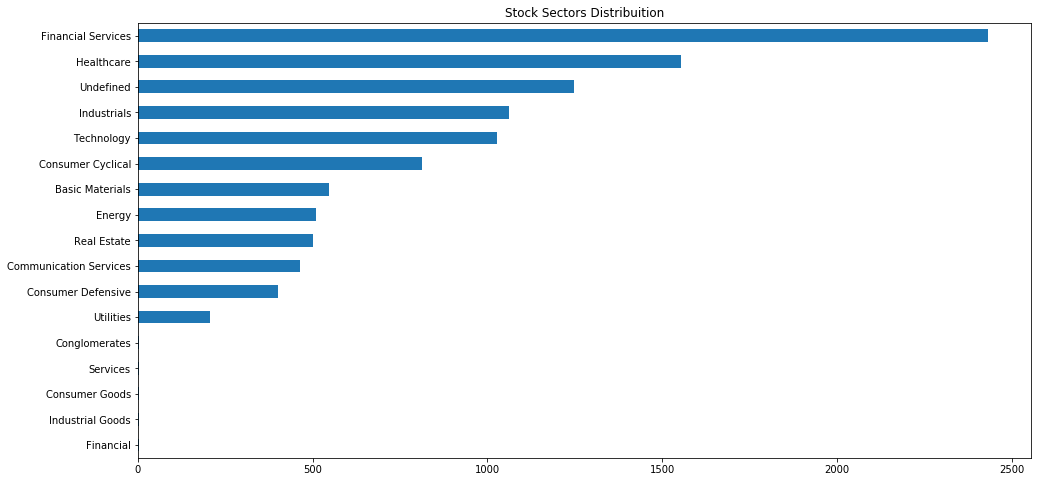

In [12]:
pl.figure(figsize=(16,8));
tickers.sector.value_counts().plot(kind='barh', title='Stock Sectors Distribuition').invert_yaxis();

Большинство компаний работают в секторах Здравоохранения и Финансовых услуг, а также в промышленности, IT и циклических индустрий. Замечу, что у нас огромная доля компаний не получила в соответствие сектор, что не очень приятно для дальнейшего анализа.

# Обработка датасета

Определяю количество лагов доли акции.

In [3]:
num_lags = 4

MAX_FILING = pow(10,13)
MAX_SSH_PRN_AMP = pow(10, 8)
MAX_MVAL = pow(10, 10)

In [3] used 8.4297 MiB RAM in 0.12s, peaked 0.00 MiB above current, total RAM usage 1856.55 MiB


Чищу данные.

In [4]:
%%time
# оставляю только акции
df = df[df['security_class'] == "STOCK"]
# беру только самодостаточные активы
df = df[df['investment_discretion'] == "SOLE"]
# оставляю только обыкновенные акции с неразделимым правом на голосовании
df = df[(df['voting_authority_sole'] > 0) & (df['voting_authority_shared'] + df['voting_authority_none'] == 0)]
# Убираю наблюдения, которые являются опционами на акции
df = df[df['put_call'].isna()]

# Создаю переменную количества акций

# Создаю маску, указывающую, где стоит число акций
df = df[df['ssh_prn_amt_type'] == 'SH']
# Нахожу количество акций через отношение стоимости позиции и цены закрытия, если количество не было указано
df['shares'] = df.ssh_prn_amt

# Почему-то в датасете есть позиции, на которых стоит нулевая стоимость или нулевое количество
mvsum = df.groupby('access_id').market_value.sum().reset_index()
df = df[(df.market_value > 0) & (df.shares > 0) & \
                (df.shares < MAX_SSH_PRN_AMP) & (df.market_value < MAX_MVAL) & \
                df.access_id.isin(mvsum[mvsum.market_value < MAX_FILING].access_id.unique())]

del mvsum

df['close'] = df.market_value.div(df.shares, axis=0)

df = df[(pd.to_datetime(df['stamp']) - pd.to_datetime(df['conformed_period_of_report']) < '250d')]

# перевожу дату в кварталы
df['period'] = pd.to_datetime(df.conformed_period_of_report).dt.to_period('Q')

# оставляю нужные колонки и перевожу в нужные форматы
df = df[['shares', 'market_value', 'cik', 'period', 'id', 'conformed_submission_type', 'close', 'access_id', 'stamp']].dropna()
df['shares'] = df['shares'].round()
df['ticker_id'] = df['id'].astype('int')
df['cik'] = df['cik'].astype('int')
df.drop('id', axis=1, inplace=True)

Wall time: 32.6 s
In [4] used -1412.6562 MiB RAM in 32.69s, peaked 3799.43 MiB above current, total RAM usage 443.89 MiB


Теперь я хочу учесть влияние поправок к основным отчетам. Как сказано в сведениях, в поправках указываются окончательные позиции по активам. Значит, моя задача - оставить только поправки.

Во-первых, проверю, что в поправках указываются именно окончательные позиции, а изменения. Для этого посмотрю, нет ли отрицательных значений количества акций в наблюдениях поправок.

In [5]:
amends = df[df.conformed_submission_type == '13F-HR/A']
amends[amends.shares < 0].shape[0]

0

In [5] used 19.1016 MiB RAM in 0.44s, peaked 0.00 MiB above current, total RAM usage 462.99 MiB


Так как в моих данных одной комбинации "Период - Тикер - Фонд" может соответствовать несколько наблюдений, как для основного отчета, так и для поправок, и эти наблюдения в отчете и поправках могут не совпадать, то я посчитаю суммы по комбинациям выше и типам отчета. Кроме того, так как фонды могут загружать основные отчеты и поправки в разное время, то я возьму тот тип отчета, который был загружен последним для каждой комбинации.

In [6]:
%%time

df = df.groupby(by=['cik', 'period', 'ticker_id', 'access_id', 'conformed_submission_type']).agg({'shares': 'sum',
                                                             'market_value': 'sum',
                                                             'stamp': 'max',
                                                             'close': 'max'}).reset_index()

df = df.sort_values(by='stamp').groupby(['cik', 'period', 'ticker_id']).last().reset_index()

Wall time: 8min 2s
In [6] used -117.9531 MiB RAM in 482.77s, peaked 1211.85 MiB above current, total RAM usage 345.04 MiB


Теперь постараюсь посмотреть, есть ли смысл использовать сектор компании для анализа вопроса. Посмотрим, какому количеству данных соответствует сектор.

In [17]:
# Привязываю данные о тикерах к основнуму датасету.
data = df.merge(tickers, how='left', on='ticker_id', suffixes=(None, None))

# Вывожу долю покрытия данными о тикерами
print(str(round(data[~data.ticker.isna()].shape[0] / data.shape[0] * 100, 3)) + '% covered by sectoral mapping')

0.392% covered by sectoral mapping


Как мы видим, соответствием в базе тикеров обладает меньше процента наблюдений. Поэтому я не буду включать данные о секторе в разработку модели.

Для красоты отсортирую данные и удобства отсортирую данные. 

In [7]:
%%time

not_in_df = df.pivot(index='period', columns=['cik', 'ticker_id'], values='shares') \
                                .isna().unstack().reset_index(name='nid')

not_in_df = not_in_df[not_in_df.nid]

df = df.merge(not_in_df, on=['cik', 'ticker_id', 'period'], how='outer', suffixes=(False, False))

df['_object'] = df.cik.apply(str) + '_' + df.ticker_id.apply(str) + '_' + df.period.apply(str)

df['shares'] = df.shares.fillna(0)
df['market_value'] = df.market_value.fillna(0)

Wall time: 1min 51s
In [7] used 1121.2305 MiB RAM in 112.04s, peaked 1853.75 MiB above current, total RAM usage 1466.27 MiB


In [8]:
%%time

# Сортирую данные
df = df.sort_values(by=['ticker_id', 'cik', 'period'])

Wall time: 16.8 s
In [8] used 468.1094 MiB RAM in 16.96s, peaked 1362.43 MiB above current, total RAM usage 1934.38 MiB


Отлично, у меня теперь MemoryError. Что же придется, уменьшить выборку.

In [151]:
# копирую датасет для возможности бэк-апа
final_df = df[df.cik.isin(np.random.choice(df.cik.unique(), 1000, replace=False))].copy(deep=True)

In [151] used -10.4844 MiB RAM in 8.60s, peaked 1682.68 MiB above current, total RAM usage 1702.86 MiB


## Размер фондов

Сначала я создаю таблицу накопленной ценности инвестора в каждый квартал.

In [152]:
funds_value = final_df.groupby(by=['period', 'cik'])['market_value'].sum().reset_index()
funds_value = funds_value[funds_value.market_value > 0]

In [152] used 7.3984 MiB RAM in 0.54s, peaked 139.98 MiB above current, total RAM usage 1710.25 MiB


Формирую пороговые значения низкой и высокой стоимости. Их я выбирал так, чтобы они примерно поровну делили выборку по размеру.

In [153]:
funds_value.head()

,period,cik,market_value
219,2015Q3,1098490,3.238080e+08
627,2015Q3,1552981,2.347360e+08
720,2015Q3,1595082,2.395160e+08
1004,2015Q4,38777,4.440000e+05
1033,2015Q4,728889,4.304194e+09


In [153] used 2.3945 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 1712.65 MiB


In [154]:
high_value = np.quantile(funds_value.market_value, 2/3)
low_value = np.quantile(funds_value.market_value, 1/3)

high_value, low_value

(393908999.9999999, 96126999.99999997)

In [154] used 0.4375 MiB RAM in 0.12s, peaked 0.00 MiB above current, total RAM usage 1713.09 MiB


Рассмотрим некоторые основные описательные статистики.

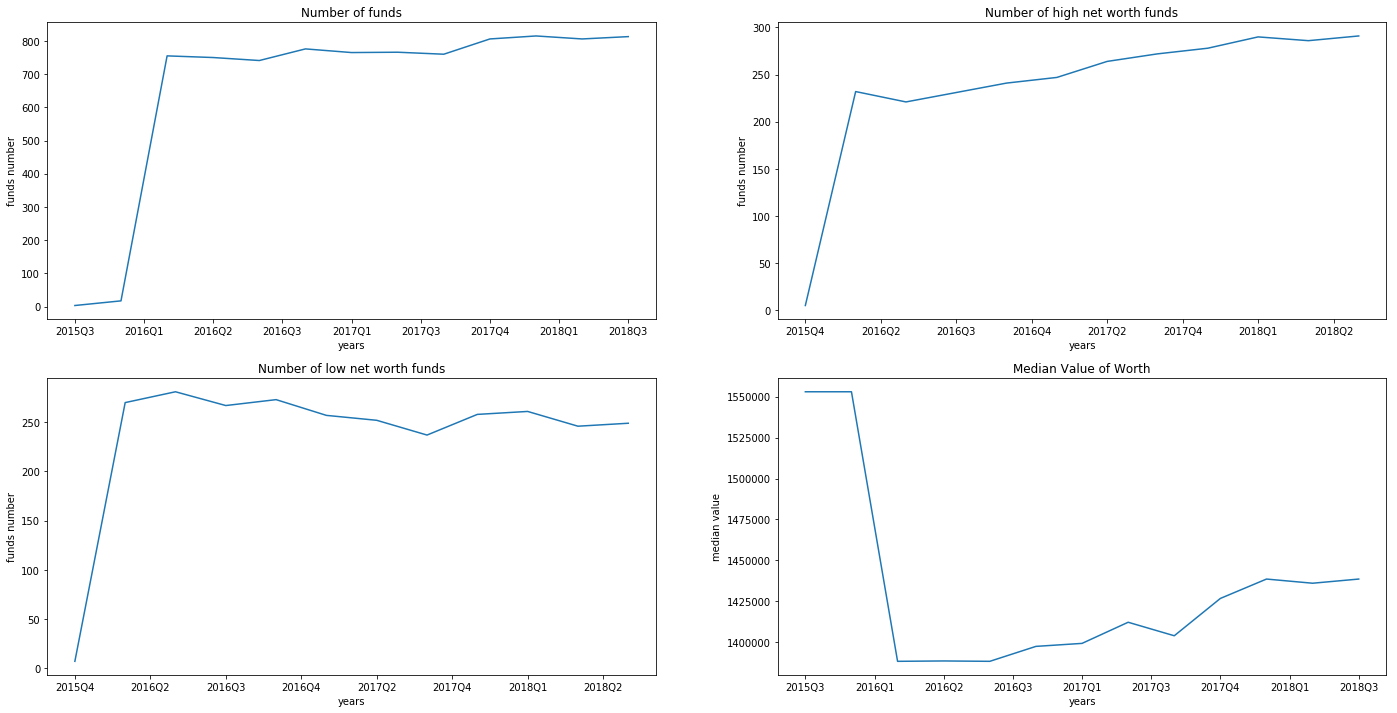

In [155] used 21.0898 MiB RAM in 1.12s, peaked 5.54 MiB above current, total RAM usage 1734.18 MiB


In [155]:
fig, axs = pl.subplots(2, 2, figsize=(24, 12));

plot_data = funds_value.groupby('period')['cik'].nunique()
axs[0, 0].plot(plot_data.index.to_series().astype(str), plot_data.values);
axs[0, 0].set_title('Number of funds');
axs[0, 0].set(xlabel='years', ylabel='funds number');
# axs[0, 0].tick_params(axis='x', labelsize=8);
axs[0, 0].xaxis.set_major_locator(pl.MaxNLocator(10));

plot_data = funds_value[funds_value.market_value > high_value].groupby('period')['cik'].nunique()
axs[0, 1].plot(plot_data.index.to_series().astype(str), plot_data.values);
axs[0, 1].set_title('Number of high net worth funds');
axs[0, 1].set(xlabel='years', ylabel='funds number');
axs[0, 1].xaxis.set_major_locator(pl.MaxNLocator(10));

plot_data = funds_value[funds_value.market_value < low_value].groupby('period')['cik'].nunique()
axs[1, 0].plot(plot_data.index.to_series().astype(str), plot_data.values);
axs[1, 0].set_title('Number of low net worth funds');
axs[1, 0].set(xlabel='years', ylabel='funds number');
axs[1, 0].xaxis.set_major_locator(pl.MaxNLocator(10));

plot_data = funds_value.groupby('period')['cik'].median()
axs[1, 1].plot(plot_data.index.to_series().astype(str), plot_data.values);
axs[1, 1].set_title('Median Value of Worth');
axs[1, 1].set(xlabel='years', ylabel='median value');
axs[1, 1].xaxis.set_major_locator(pl.MaxNLocator(10));

Мы видим, что в нашем датасете до 2017 года фондов почти не было (их было меньше 100). Далее произошло резкое увеличение числа инвесторов, причем значительную их долю составили средние фонды, которые продолжают доминировать по количеству. Замеиим, что медианная стоимость упала в первом квартале 2016-го года, когда бурно увеличилось количество фондов в выборке. Это означает, что большинство пришедших фондов, несмотря на мое деление, были ближе к бедным, чем к богатым. Кроме того, в последнее время количество фондов в выборке уменьшилось. 

In [156]:
final_df = final_df[final_df.period >= '2016Q1']

In [156] used -49.9258 MiB RAM in 0.92s, peaked 354.47 MiB above current, total RAM usage 1684.25 MiB


Теперь я посмотрю на распределение ценности фондов.

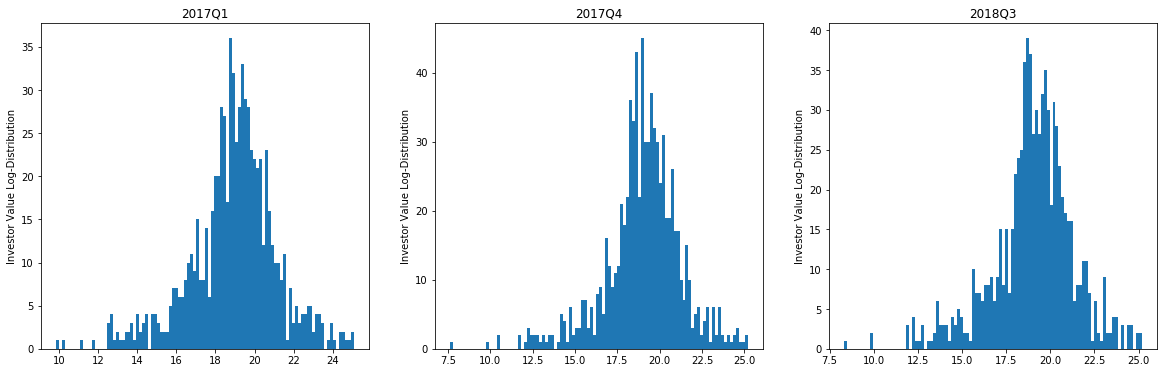

In [157] used 8.7773 MiB RAM in 0.94s, peaked 2.30 MiB above current, total RAM usage 1693.03 MiB


In [157]:
fig, axs = pl.subplots(1, 3, figsize=(20,6));

axs[0].hist(funds_value[funds_value.period == '2017Q1'].market_value.apply(np.log), bins=100);
axs[0].set_title('2017Q1');

axs[1].hist(funds_value[funds_value.period == '2017Q4'].market_value.apply(np.log), bins=100);
axs[1].set_title('2017Q4');

axs[2].hist(funds_value[funds_value.period == '2018Q3'].market_value.apply(np.log), bins=100);
axs[2].set_title('2018Q3');

for ax in axs.flat:
    ax.set(ylabel='Investor Value Log-Distribution')

Из графиков видно, что распределение незначительно изменялось за последние 2 года. Оно похоже на нормальное (то есть, если мы перейдем из логарифма к изначальным значениям, оно будет логнормальным. Только левый хвост у него больше, так как большинство фондов ближе к бедным, как говорилось выше.

Теперь создам дополнительные регрессоры.

In [158]:
final_df = final_df.merge(funds_value, on=['cik', 'period'], how='left', suffixes=('', '_fund'))
# Логарифмирую ценность фонда как всякую денежную величину
final_df['log_value_fund'] = np.log(final_df.market_value_fund)
# Создаю индикаторные переменные, указывающие на принадлежность фонда к весовой категории
final_df['value_cat'] = pd.cut(final_df.market_value_fund, [0, low_value, high_value, final_df.market_value_fund.max()],
                              labels=['low', 'med', 'high'])

In [158] used 52.3008 MiB RAM in 2.92s, peaked 343.57 MiB above current, total RAM usage 1745.33 MiB


In [159]:
final_df = final_df[~final_df.market_value_fund.isna()]
final_df = final_df.sort_values(by=['ticker_id', 'cik', 'period'])

In [159] used -40.0859 MiB RAM in 3.10s, peaked 456.39 MiB above current, total RAM usage 1705.24 MiB


Создаю лаговые значения, связанные с акциями, для каждого наблюдения. Кроме того, создаю основную переменную, представляющую изменение количества акций тикера. Её я и буду предсказывать. Важно уточнить, что изменение считается от количества акций в предыдущем квартале.

In [160]:
%%time

# Считаю разницу кварталов, чтобы брать только те значения для лагов, которые из предыдущего квартала

# Иначе может выйти так, что я буду создавать лаги на наблюдение, которое было несколько кварталов назад
# Такая ситуация нам не нужна, так как это означает, что фирма тогда закончила инвестирование в эту акцию,
# а потом заново возобновила по другим, возможно, причинам, и начался новый цикл инвестирования в этот тикер
final_df['quarter_sum'] = final_df.period.dt.year * 4 + final_df.period.dt.quarter - 1

# Добавлю индекс комбинации тикера и инвестора для удобства в агрегировании
final_df['object'] = final_df.ticker_id.apply(str) + '_' + final_df.cik.apply(str)

# Создаю лаги для переменных размера фондов
for lag in range(1, num_lags + 1):

    final_df['market_value_fund_lag' + '_' + str(lag)] = final_df.market_value_fund.shift(periods=lag). \
                                              where((final_df.object == final_df.object.shift(periods=lag)) &
                                                    (final_df.quarter_sum.diff(periods=lag) == lag))
    if lag == 1:
        
        final_df['diff_value_fund_lag' + '_' + str(lag)] = \
            (final_df['market_value_fund'] - final_df['market_value_fund_lag' + '_' + str(lag)])
        
        final_df['diff_value_fund_rank_lag' + '_' + str(lag)] = final_df['diff_value_fund_lag' + '_' + str(lag)].rank(pct=True)
    
    else:
        final_df['diff_value_fund_lag' + '_' + str(lag)] = \
            (final_df['market_value_fund_lag' + '_' + str(lag - 1)] - final_df['market_value_fund_lag' + '_' + str(lag)])
        
        final_df['diff_value_fund_rank_lag' + '_' + str(lag)] = final_df['diff_value_fund_lag' + '_' + str(lag)].rank(pct=True)
        
# Создаю переменную, выражающую долю акции в потрфеле

final_df['ticker_share'] = final_df.market_value.div(final_df.market_value_fund, axis=0)

Wall time: 5.82 s
In [160] used 681.8789 MiB RAM in 5.93s, peaked 65.67 MiB above current, total RAM usage 2387.12 MiB


## Создание зависимой переменной

In [161]:
final_df['ym_stamp'] = pd.to_datetime(final_df.stamp).dt.to_period('M')

In [161] used 41.3203 MiB RAM in 0.59s, peaked 0.00 MiB above current, total RAM usage 2428.44 MiB


In [162]:
prices = final_df.groupby(['period', 'ticker_id', 'ym_stamp'])['close'].median().reset_index()
prices.rename(columns={'close': 'mode_close'}, inplace=True)

prices = prices.groupby(['period', 'ticker_id']).first().reset_index().drop('ym_stamp', axis=1)

final_df = final_df.merge(prices, on=['period', 'ticker_id'], suffixes=(False, False), how='left')

final_df['close'] = final_df.close.fillna(final_df.mode_close)

In [162] used 68.1797 MiB RAM in 3.13s, peaked 550.52 MiB above current, total RAM usage 2496.62 MiB


In [163]:
%%time

final_df['close_lag_1'] = final_df.close.shift(periods=1). \
                                          where((final_df.object == final_df.object.shift(periods=1)) &
                                                (final_df.quarter_sum.diff(periods=1) == 1))

final_df['shares_lag_1'] = final_df.shares.shift(periods=1). \
                                          where((final_df.object == final_df.object.shift(periods=1)) &
                                                (final_df.quarter_sum.diff(periods=1) == 1))

final_df['net_changes'] = final_df.close_lag_1 * (final_df.shares - final_df.shares_lag_1) \
                                                            / final_df.market_value_fund_lag_1

net_changes = final_df.groupby(by=['period', 'cik']).agg({'net_changes': lambda x: x.abs().sum(min_count=1)}).reset_index()

final_df = final_df.merge(net_changes, on=['period', 'cik'], how='left', suffixes=('', '_abs_sum'))

final_df['pct_in_change'] = final_df.net_changes.div(final_df.net_changes_abs_sum.add(1e-20), axis = 0)

# Создаю предсказываю переменную и её лаги
for lag in range(1, num_lags + 1):

    final_df['pct_in_change' + '_' + str(lag)] = final_df.pct_in_change.shift(periods=lag). \
                                              where((final_df.object == final_df.object.shift(periods=lag)) &
                                                    (final_df.quarter_sum.diff(periods=lag) == lag))
    
    final_df['net_changes' + '_' + str(lag)] = final_df.net_changes.shift(periods=lag). \
                                              where((final_df.object == final_df.object.shift(periods=lag)) &
                                                    (final_df.quarter_sum.diff(periods=lag) == lag))

Wall time: 6.33 s
In [163] used 245.5703 MiB RAM in 6.44s, peaked 522.39 MiB above current, total RAM usage 2742.19 MiB


But at what cost?

In [164]:
final_df[final_df.net_changes < -1].net_changes

996512    -1.0
2019597   -1.0
2319995   -1.0
Name: net_changes, dtype: float64

In [164] used -1105.0547 MiB RAM in 3.10s, peaked 1927.32 MiB above current, total RAM usage 1637.14 MiB


In [165]:
final_df[(final_df.close - final_df.mode_close).abs() >= 7][['cik', 'period', 'ticker_id', 'shares', 'market_value',
                                                                  'close', 'mode_close']].head(20)

,cik,period,ticker_id,shares,market_value,close,mode_close
181,1641866,2018Q3,779,66.0,2000.0,30.303030,37.792344
647,1641866,2016Q1,780,62.0,1000.0,16.129032,23.274162
648,1641866,2016Q2,780,62.0,1000.0,16.129032,23.337681
1362,1588539,2018Q2,829,72.0,1000.0,13.888889,22.607722
1363,1588539,2018Q3,829,72.0,1000.0,13.888889,21.467330
1475,1732854,2017Q4,829,224.0,35000.0,156.250000,23.139492
1608,884423,2016Q3,835,11.0,1000.0,90.909091,9.523810
1716,1134008,2017Q2,835,47.0,1000.0,21.276596,11.641221
2011,1659047,2016Q1,835,27.0,1000.0,37.037037,8.976975
2047,1696064,2017Q2,835,47.0,1000.0,21.276596,11.641221


In [165] used 35.8164 MiB RAM in 0.29s, peaked 4.83 MiB above current, total RAM usage 1672.95 MiB


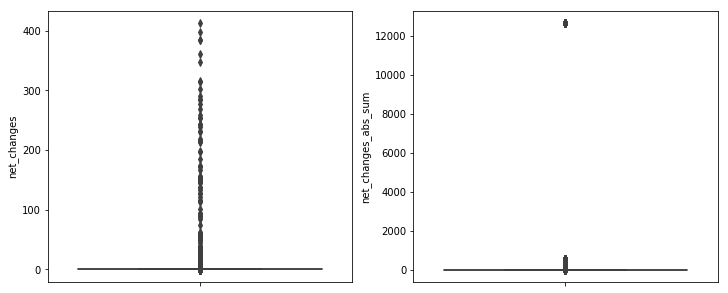

In [166] used 84.7266 MiB RAM in 4.23s, peaked 23.85 MiB above current, total RAM usage 1757.68 MiB


In [166]:
fig, ax = pl.subplots(1,2, figsize=(12,5));
sns.boxplot(y=final_df["net_changes"], ax=ax[0]);
sns.boxplot(y=(final_df["net_changes_abs_sum"]), ax=ax[1]);
fig.show();

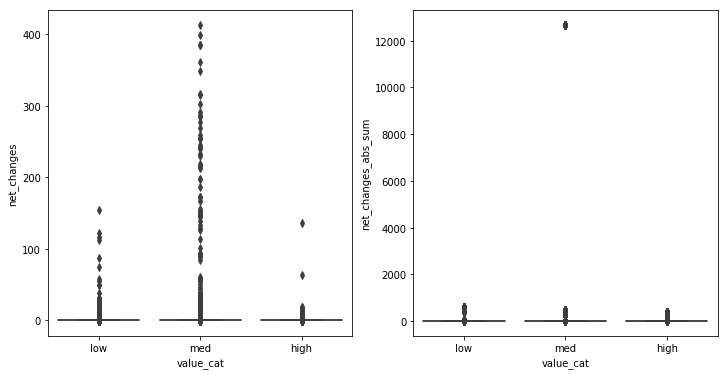

In [167] used 78.8906 MiB RAM in 5.17s, peaked 31.92 MiB above current, total RAM usage 1836.57 MiB


In [167]:
fig, ax = pl.subplots(1,2, figsize=(12,6));
sns.boxplot(x="value_cat", y="net_changes", data=final_df, ax=ax[0]);
sns.boxplot(x="value_cat", y="net_changes_abs_sum", data=final_df, ax=ax[1]);

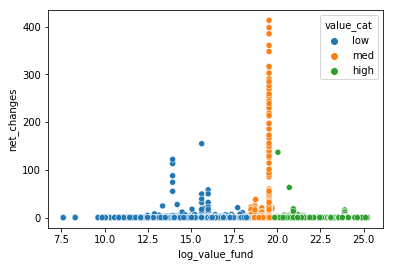

In [168] used 306.4023 MiB RAM in 99.21s, peaked 132.89 MiB above current, total RAM usage 2142.97 MiB


In [168]:
sns.scatterplot(x='log_value_fund', y='net_changes', hue='value_cat', data=final_df);

Проблема просто net_changes в том, что в нем могут быть аутлаеры и изменения сравниваются не с собой, а с имеющимися и накопленными активами.

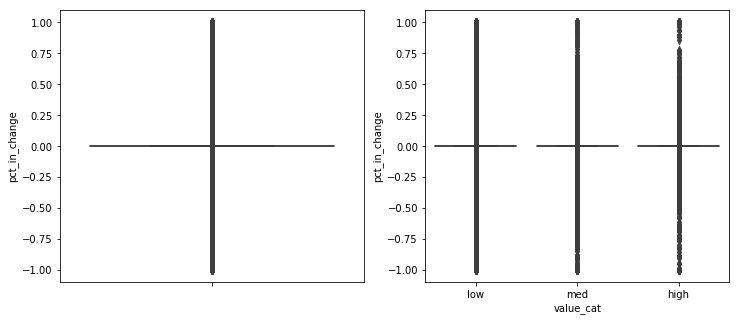

In [169] used 122.2344 MiB RAM in 7.60s, peaked 19.73 MiB above current, total RAM usage 2265.21 MiB


In [169]:
fig, ax = pl.subplots(1,2, figsize=(12,5));
sns.boxplot(y="pct_in_change", data=final_df, ax=ax[0]);
sns.boxplot(x="value_cat", y="pct_in_change", data=final_df, ax=ax[1]);

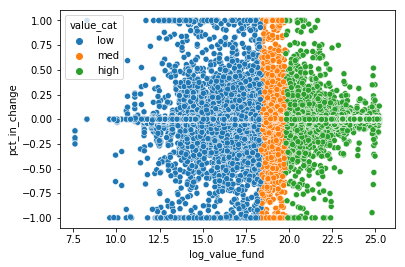

In [170] used 53.3984 MiB RAM in 144.63s, peaked 185.24 MiB above current, total RAM usage 2318.61 MiB


In [170]:
sns.scatterplot(x='log_value_fund', y='pct_in_change', hue='value_cat', data=final_df);

## Метрики стиля инвестирования

Сейчас я посмотрю на то, как фонды торгуют через призму стандартных метрик. С помощью этого я постараюсь добавить переменные, которые бы контролировали стиль фонда, ибо в зависимости от стиля инвестирования может меняться отношение к активам.

### Turnover и HHI

Считаю такие классные и потрясающие (реально же) метрики как turnover и индекс Херфиндаля-Хиршмана (HHI) для того, чтобы разграничить фонды по типам инвестирования и проводить контроль по ним. 

Сначала вычислю turnover.

In [171]:
final_df['ticker_share_lag_1'] = final_df.ticker_share.shift(periods=1). \
                                          where((final_df.object == final_df.object.shift(periods=1)) &
                                                (final_df.quarter_sum.diff(periods=1) == 1))

final_df['ticker_share_lag_2'] = final_df.ticker_share.shift(periods=2). \
                                          where((final_df.object == final_df.object.shift(periods=4)) &
                                                (final_df.quarter_sum.diff(periods=2) == 2))

final_df['ticker_share_lag_4'] = final_df.ticker_share.shift(periods=4). \
                                          where((final_df.object == final_df.object.shift(periods=4)) &
                                                (final_df.quarter_sum.diff(periods=4) == 4))

In [171] used 61.3164 MiB RAM in 0.99s, peaked 2.52 MiB above current, total RAM usage 2379.92 MiB


In [172]:
turnover = final_df.groupby(['period', 'cik']) \
            .apply(lambda x: np.abs(x['ticker_share'] - x['ticker_share_lag_1']).sum(min_count=1)).reset_index()
turnover.rename(columns={0: 'turnover'}, inplace=True)
turnover.sample(5)

,period,cik,turnover
6241,2018Q1,1021926,0.627641
2071,2016Q3,1569537,0.609157
7509,2018Q2,1590144,1.001106
7599,2018Q2,1647273,0.481637
1426,2016Q2,1616628,1.947573


In [172] used -950.3242 MiB RAM in 16.02s, peaked 1954.52 MiB above current, total RAM usage 1429.60 MiB


In [173]:
turnover_halfyear = final_df.groupby(['period', 'cik']) \
            .apply(lambda x: np.abs(x['ticker_share'] - x['ticker_share_lag_2']).sum(min_count=1)).reset_index()
turnover_halfyear.rename(columns={0: 'turnover_halfyear'}, inplace=True)
turnover_halfyear.sample(5)

,period,cik,turnover_halfyear
2951,2016Q4,1654648,NaN
4115,2017Q2,1352306,1.179286
8204,2018Q3,1512734,0.038087
1442,2016Q2,1632554,NaN
6793,2018Q1,1647273,0.419702


In [173] used 8.6328 MiB RAM in 11.33s, peaked 2006.04 MiB above current, total RAM usage 1438.23 MiB


In [174]:
turnover_year = final_df.groupby(['period', 'cik']) \
            .apply(lambda x: np.abs(x['ticker_share'] - x['ticker_share_lag_4']).sum(min_count=1)).reset_index()
turnover_year.rename(columns={0: 'turnover_year'}, inplace=True)
turnover_year.sample(5)

,period,cik,turnover_year
7517,2018Q2,1593404,1.302501
2460,2016Q4,1123778,NaN
16,2016Q1,200217,NaN
1400,2016Q2,1599863,NaN
7020,2018Q2,923469,0.601899


In [174] used 0.4805 MiB RAM in 11.43s, peaked 2006.11 MiB above current, total RAM usage 1438.71 MiB


Теперь HHI.

In [175]:
hhi = final_df.groupby(['period', 'cik']) \
            .apply(lambda x: np.square(x['ticker_share']).sum(min_count=1)).reset_index()
hhi.rename(columns={0: 'hhi'}, inplace=True)
hhi.head()

,period,cik,hhi
0,2016Q1,5272,0.010643
1,2016Q1,7789,0.045664
2,2016Q1,9015,0.004477
3,2016Q1,36644,0.074046
4,2016Q1,38777,0.508407


In [175] used 0.4922 MiB RAM in 10.32s, peaked 2006.13 MiB above current, total RAM usage 1439.20 MiB


Теперь посмотрю на их распределение.

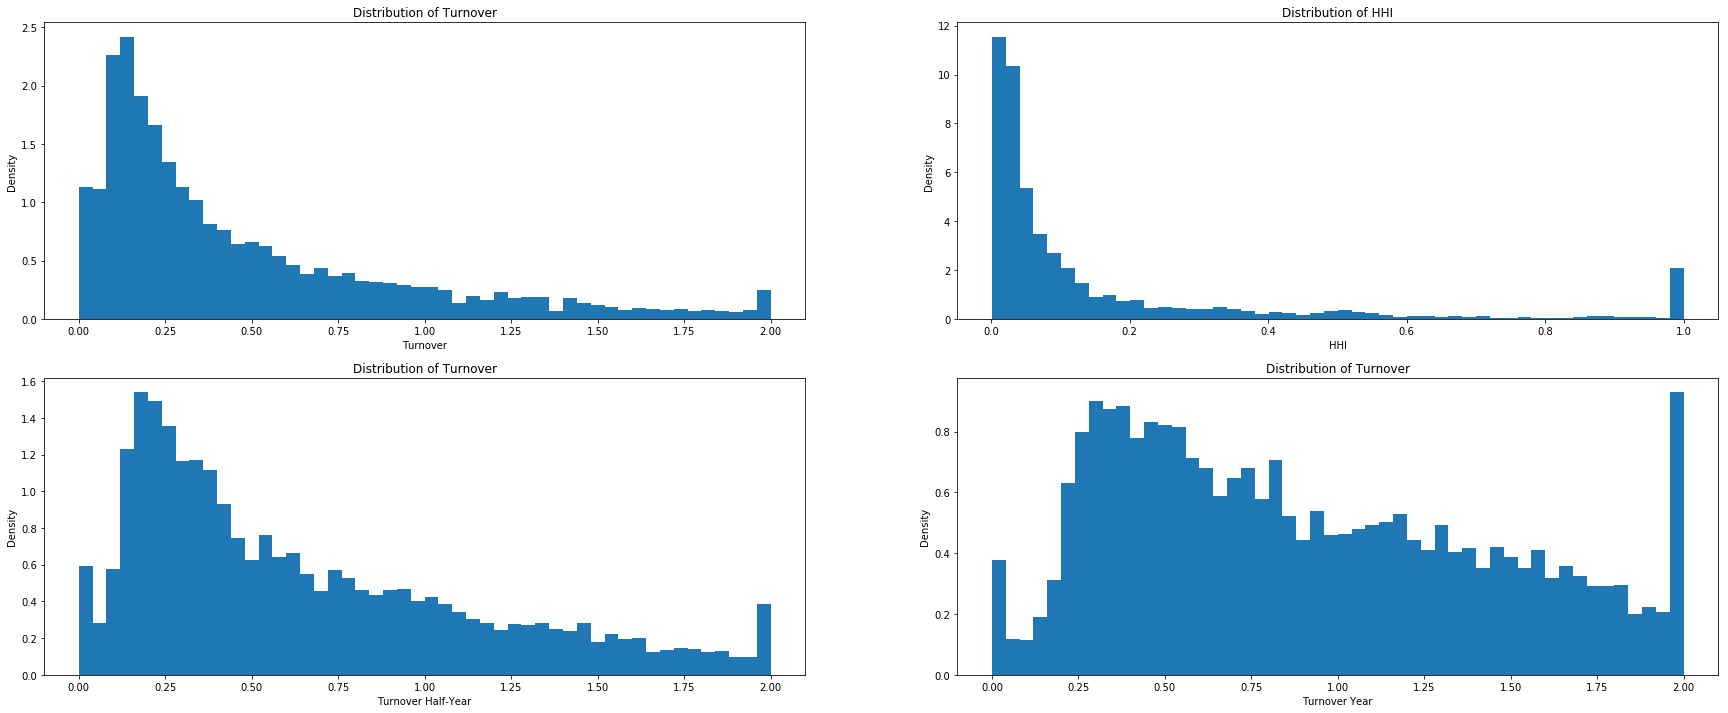

In [176] used 15.8008 MiB RAM in 0.90s, peaked 6.87 MiB above current, total RAM usage 1455.00 MiB


In [176]:
fig, axs = pl.subplots(2, 2, figsize=(30,12));

axs[0, 0].hist(turnover.turnover, density=True, bins=50);
axs[0, 0].set_title('Distribution of Turnover');
axs[0, 0].set(xlabel='Turnover', ylabel='Density');

axs[0, 1].hist(hhi.hhi, density=True, bins=50);
axs[0, 1].set_title('Distribution of HHI');
axs[0, 1].set(xlabel='HHI', ylabel='Density');

axs[1, 0].hist(turnover_halfyear.turnover_halfyear, density=True, bins=50);
axs[1, 0].set_title('Distribution of Turnover');
axs[1, 0].set(xlabel='Turnover Half-Year', ylabel='Density');

axs[1, 1].hist(turnover_year.turnover_year, density=True, bins=50);
axs[1, 1].set_title('Distribution of Turnover');
axs[1, 1].set(xlabel='Turnover Year', ylabel='Density');

Можно заметить, что их распределения похожи на геометрическое/Пуассона. Можно разграничить фонды по этим категориям, установив границы для каждого из критерия. Например, 0.5 для Turnover и 0.2 для HHI. Также отметим условно экстремальные ситуации, когда и Turnover, и HHI равны единице.

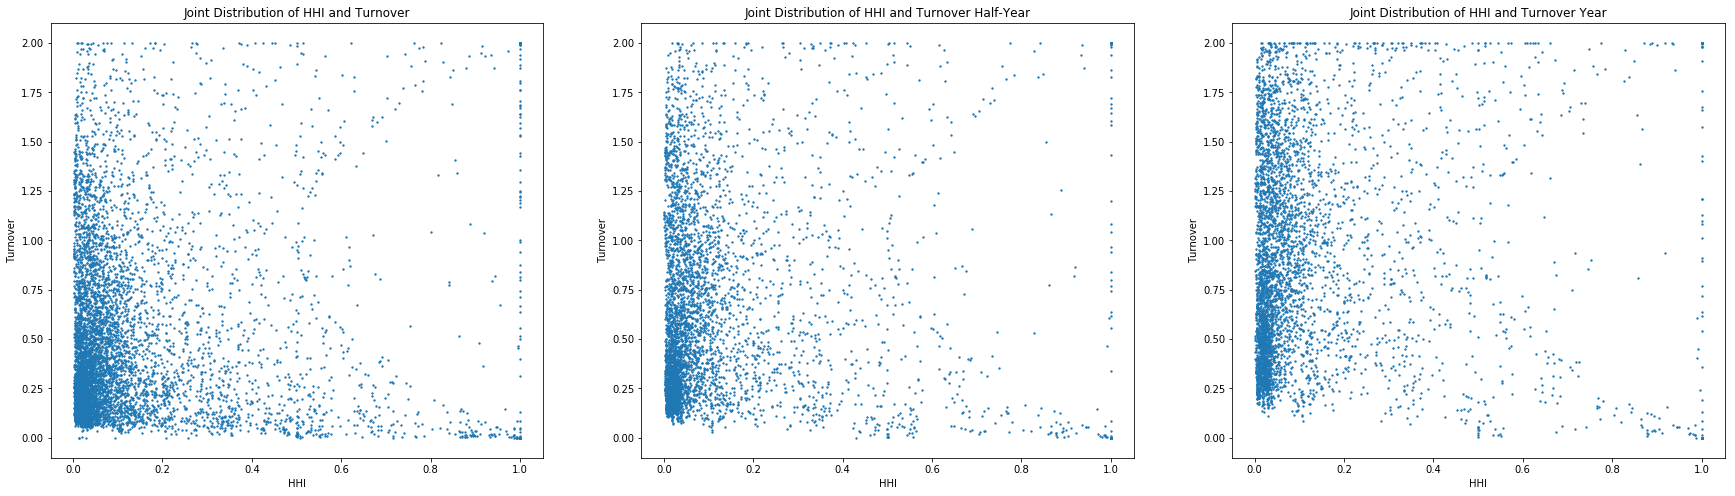

In [177] used 6.4961 MiB RAM in 0.57s, peaked 3.99 MiB above current, total RAM usage 1461.50 MiB


In [177]:
fig, axs = pl.subplots(1, 3, figsize=(30,8));

axs[0].scatter(hhi.hhi, turnover.turnover, s=1.8);
axs[0].set_xlabel('HHI');
axs[0].set_ylabel('Turnover');
axs[0].set_title('Joint Distribution of HHI and Turnover');

axs[1].scatter(hhi.hhi, turnover_halfyear.turnover_halfyear, s=1.8);
axs[1].set_xlabel('HHI');
axs[1].set_ylabel('Turnover');
axs[1].set_title('Joint Distribution of HHI and Turnover Half-Year');

axs[2].scatter(hhi.hhi, turnover_year.turnover_year, s=1.8);
axs[2].set_xlabel('HHI');
axs[2].set_ylabel('Turnover');
axs[2].set_title('Joint Distribution of HHI and Turnover Year');

Если мы посмотрим на совместное их распределение, то не увидим каких-то кластеров. Но подозрительно выделяются наблюдения с HHI=1 (фонды с одной акцией). Вопрос - как такие фонды существуют/как они попали к нам в выборку? Установим контроль и на них.

Добавляю переменные на основе наблюдений.

In [178]:
# Добавляю сами индексы
final_df = final_df.merge(turnover, on=['cik', 'period'], how='left', suffixes=(False, False))
final_df = final_df.merge(turnover_halfyear, on=['cik', 'period'], how='left', suffixes=(False, False))
final_df = final_df.merge(turnover_year, on=['cik', 'period'], how='left', suffixes=(False, False))
final_df = final_df.merge(hhi, on=['cik', 'period'], how='left', suffixes=(False, False))

# Устанавливаю контроль на фонды с одной акцией
final_df['hhi_eq_1'] = final_df.hhi.eq(1)

In [178] used 88.3281 MiB RAM in 9.72s, peaked 1250.64 MiB above current, total RAM usage 1549.83 MiB


In [179]:
# Разграничиваю фонды по метрикам через индикаторы
final_df['hhi_cat'] = pd.cut(final_df.hhi, np.insert((1 / np.arange(10, 0, -1)) ** 1.5, 0, -1), labels=np.arange(10))
final_df['tvr_cat'] = pd.cut(final_df.turnover, np.insert((2 / np.arange(10, 0, -1)) ** 1.7, 0, -1), labels=np.arange(10))
final_df['tvr_half_cat'] = pd.cut(final_df.turnover_halfyear, np.insert((2 / np.arange(10, 0, -1)) ** 1.7, 0, -1),
                                                                                                labels=np.arange(10))
final_df['tvr_year_cat'] = pd.cut(final_df.turnover_year, np.insert((2 / np.arange(10, 0, -1)) ** 1.7, 0, -1),
                                                                                                labels=np.arange(10))

In [179] used 10.3789 MiB RAM in 0.46s, peaked 32.84 MiB above current, total RAM usage 1560.21 MiB


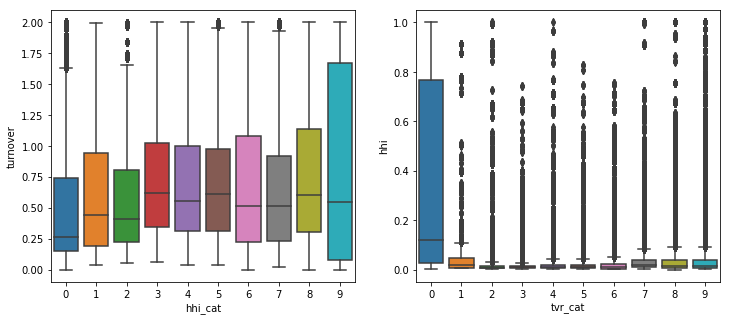

In [180] used 39.5039 MiB RAM in 1.74s, peaked 44.94 MiB above current, total RAM usage 1599.71 MiB


In [180]:
fig, ax = pl.subplots(1,2, figsize=(12,5));
sns.boxplot(x='hhi_cat', y='turnover', data=final_df, ax=ax[0]);
sns.boxplot(x='tvr_cat', y='hhi', data=final_df, ax=ax[1]);

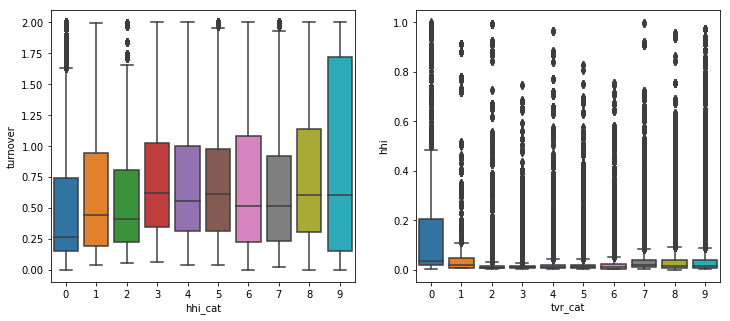

In [181] used 1351.5039 MiB RAM in 4.89s, peaked 115.29 MiB above current, total RAM usage 2951.21 MiB


In [181]:
final_df_slice = final_df[final_df.hhi.ne(1)]

fig, ax = pl.subplots(1,2, figsize=(12,5));
sns.boxplot(x='hhi_cat', y='turnover', data=final_df_slice, ax=ax[0]);
sns.boxplot(x='tvr_cat', y='hhi', data=final_df_slice, ax=ax[1]);

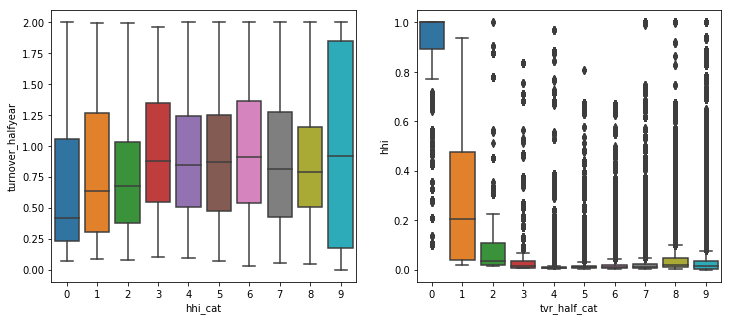

In [182] used 12.6992 MiB RAM in 1.24s, peaked 49.11 MiB above current, total RAM usage 2963.91 MiB


In [182]:
fig, ax = pl.subplots(1,2, figsize=(12,5));
sns.boxplot(x='hhi_cat', y='turnover_halfyear', data=final_df, ax=ax[0]);
sns.boxplot(x='tvr_half_cat', y='hhi', data=final_df, ax=ax[1]);

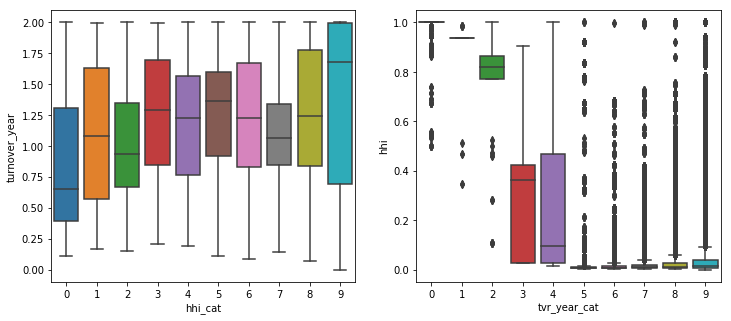

In [183] used 11.0898 MiB RAM in 1.18s, peaked 40.98 MiB above current, total RAM usage 2975.00 MiB


In [183]:
fig, ax = pl.subplots(1,2, figsize=(12,5));
sns.boxplot(x='hhi_cat', y='turnover_year', data=final_df, ax=ax[0]);
sns.boxplot(x='tvr_year_cat', y='hhi', data=final_df, ax=ax[1]);

Если мы посмотрим на совместное распределение Размера фонда и наших метрик, то опять не увидим каких-либо кластеров, по которым можно было бы провести классификацию. Печаль.

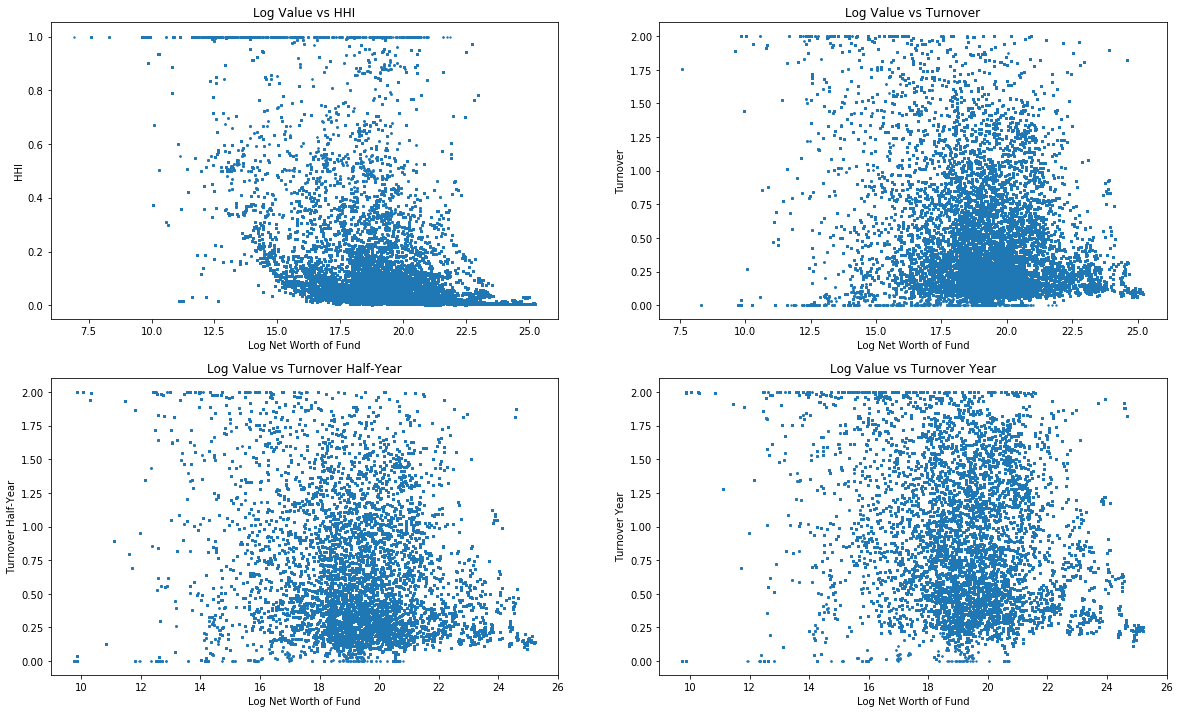

In [184] used 128.1289 MiB RAM in 59.07s, peaked 19.64 MiB above current, total RAM usage 3103.13 MiB


In [184]:
fig, axs = pl.subplots(2, 2, figsize=(20,12));

axs[0, 0].scatter(final_df.log_value_fund,
           final_df.hhi, s=1.8);
axs[0, 0].set_title('Log Value vs HHI');
axs[0, 0].set(xlabel='Log Net Worth of Fund', ylabel='HHI');

axs[0, 1].scatter(final_df.log_value_fund,
           final_df.turnover, s=1.8);
axs[0, 1].set_title('Log Value vs Turnover');
axs[0, 1].set(xlabel='Log Net Worth of Fund', ylabel='Turnover');

axs[1, 0].scatter(final_df.log_value_fund,
           final_df.turnover_halfyear, s=1.8);
axs[1, 0].set_title('Log Value vs Turnover Half-Year');
axs[1, 0].set(xlabel='Log Net Worth of Fund', ylabel='Turnover Half-Year');

axs[1, 1].scatter(final_df.log_value_fund,
           final_df.turnover_year, s=1.8);
axs[1, 1].set_title('Log Value vs Turnover Year');
axs[1, 1].set(xlabel='Log Net Worth of Fund', ylabel='Turnover Year');

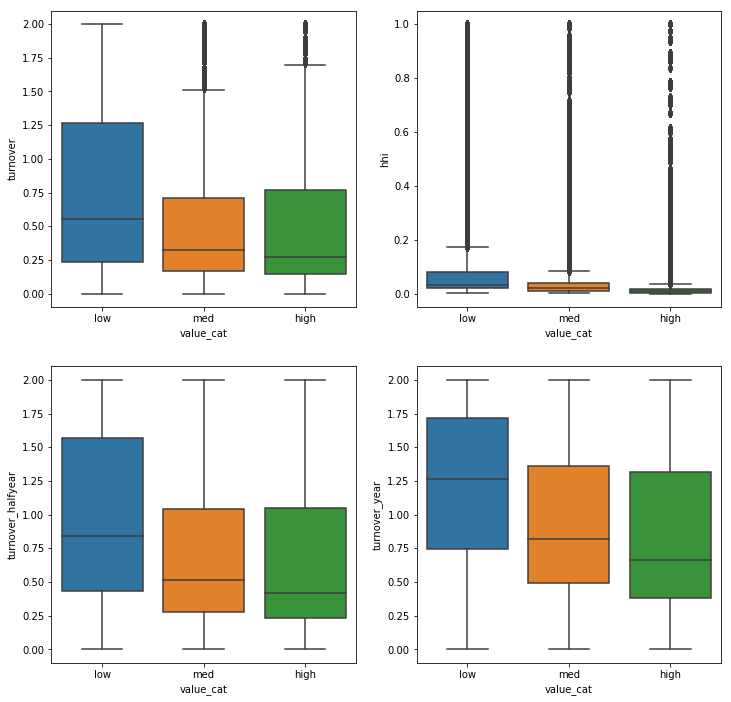

In [185] used 23.1719 MiB RAM in 2.97s, peaked 68.02 MiB above current, total RAM usage 3126.30 MiB


In [185]:
fig, ax = pl.subplots(2,2, figsize=(12,12));
sns.boxplot(x='value_cat', y='turnover', data=final_df, ax=ax[0, 0]);
sns.boxplot(x='value_cat', y='hhi', data=final_df, ax=ax[0, 1]);
sns.boxplot(x='value_cat', y='turnover_halfyear', data=final_df, ax=ax[1, 0]);
sns.boxplot(x='value_cat', y='turnover_year', data=final_df, ax=ax[1, 1]);

Теперь я посмотрю на совместное распределение с зависимой переменной изменения количества акций, чтобы лучше понять зависимость от класса фонда.

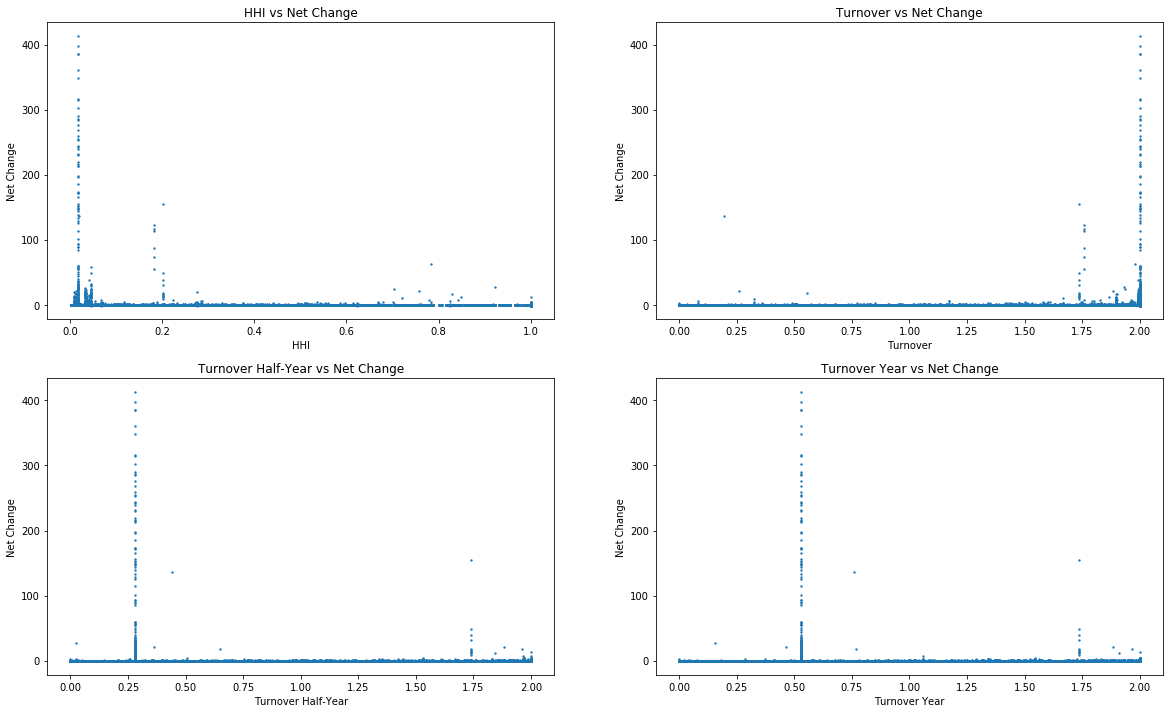

In [186] used -794.2070 MiB RAM in 92.48s, peaked 929.35 MiB above current, total RAM usage 2332.10 MiB


In [186]:
fig, axs = pl.subplots(2, 2, figsize=(20,12));

axs[0, 0].scatter(final_df.hhi,
           final_df.net_changes, s=1.8);
axs[0, 0].set_title('HHI vs Net Change');
axs[0, 0].set(xlabel='HHI', ylabel='Net Change');

axs[0, 1].scatter(final_df.turnover,
           final_df.net_changes, s=1.8);
axs[0, 1].set_title('Turnover vs Net Change');
axs[0, 1].set(xlabel='Turnover', ylabel='Net Change');

axs[1, 0].scatter(final_df.turnover_halfyear,
           final_df.net_changes, s=1.8);
axs[1, 0].set_title('Turnover Half-Year vs Net Change');
axs[1, 0].set(xlabel='Turnover Half-Year', ylabel='Net Change');

axs[1, 1].scatter(final_df.turnover_year,
           final_df.net_changes, s=1.8);
axs[1, 1].set_title('Turnover Year vs Net Change');

axs[1, 1].set(xlabel='Turnover Year', ylabel='Net Change');

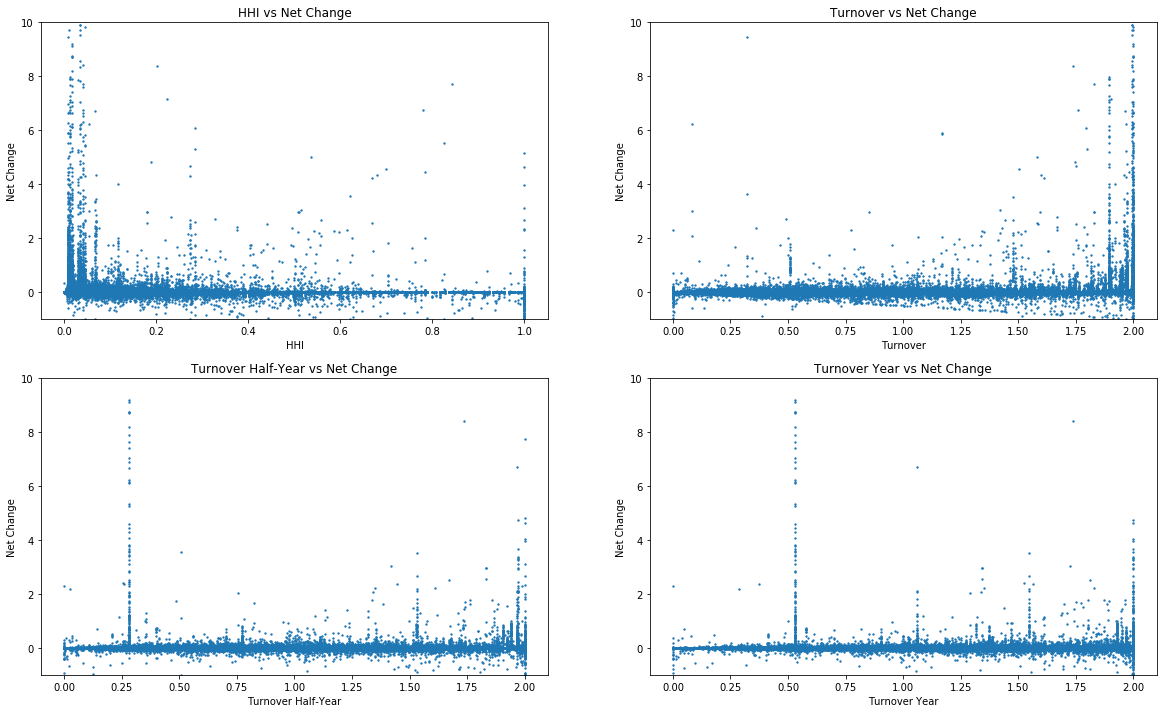

In [187] used 93.3281 MiB RAM in 81.51s, peaked 48.34 MiB above current, total RAM usage 2425.43 MiB


In [187]:
fig, axs = pl.subplots(2, 2, figsize=(20,12));

axs[0, 0].scatter(final_df.hhi,
           final_df.net_changes, s=1.8);
axs[0, 0].set_title('HHI vs Net Change');
axs[0, 0].set(xlabel='HHI', ylabel='Net Change');
axs[0, 0].set_ylim(-1, 10);

axs[0, 1].scatter(final_df.turnover,
           final_df.net_changes, s=1.8);
axs[0, 1].set_title('Turnover vs Net Change');
axs[0, 1].set(xlabel='Turnover', ylabel='Net Change');
axs[0, 1].set_ylim(-1, 10);

axs[1, 0].scatter(final_df.turnover_halfyear,
           final_df.net_changes, s=1.8);
axs[1, 0].set_title('Turnover Half-Year vs Net Change');
axs[1, 0].set(xlabel='Turnover Half-Year', ylabel='Net Change');
axs[1, 0].set_ylim(-1, 10);

axs[1, 1].scatter(final_df.turnover_year,
           final_df.net_changes, s=1.8);
axs[1, 1].set_title('Turnover Year vs Net Change');
axs[1, 1].set(xlabel='Turnover Year', ylabel='Net Change');
axs[1, 1].set_ylim(-1, 10);

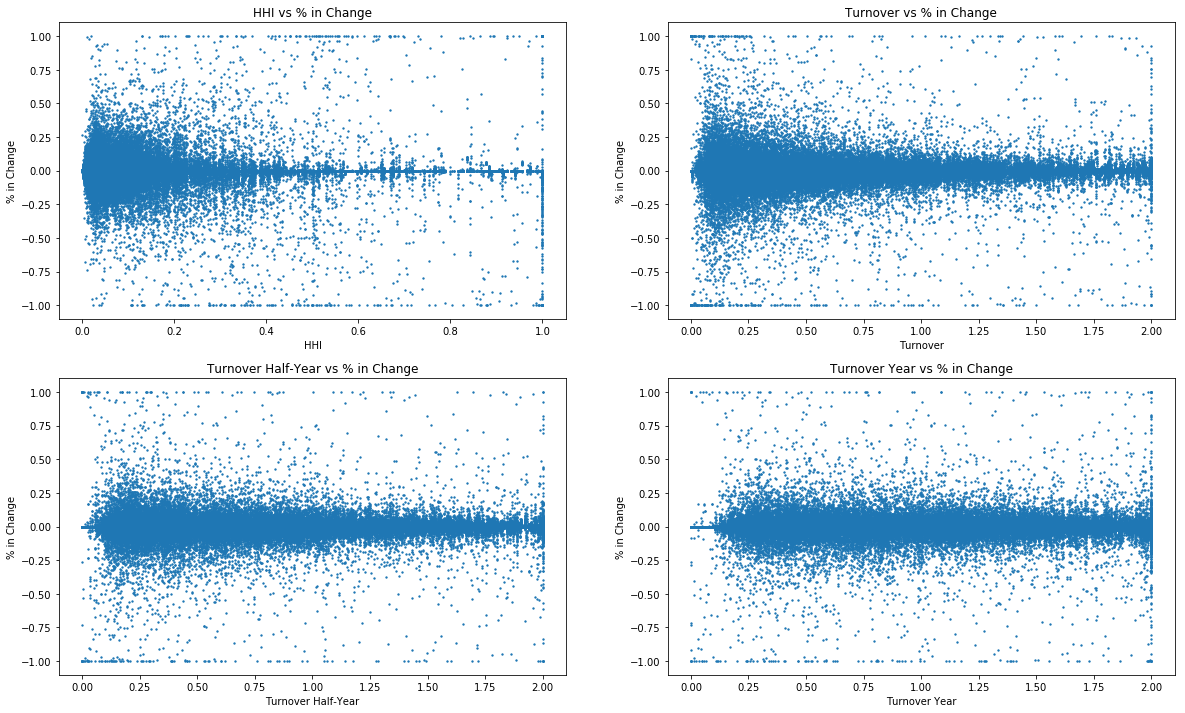

In [188] used -178.0977 MiB RAM in 55.40s, peaked 248.04 MiB above current, total RAM usage 2247.33 MiB


In [188]:
fig, axs = pl.subplots(2, 2, figsize=(20,12));

axs[0, 0].scatter(final_df.hhi,
           final_df.pct_in_change, s=1.8);
axs[0, 0].set_title('HHI vs % in Change');
axs[0, 0].set(xlabel='HHI', ylabel='% in Change');

axs[0, 1].scatter(final_df.turnover,
           final_df.pct_in_change, s=1.8);
axs[0, 1].set_title('Turnover vs % in Change');
axs[0, 1].set(xlabel='Turnover', ylabel='% in Change');

axs[1, 0].scatter(final_df.turnover_halfyear,
           final_df.pct_in_change, s=1.8);
axs[1, 0].set_title('Turnover Half-Year vs % in Change');
axs[1, 0].set(xlabel='Turnover Half-Year', ylabel='% in Change');

axs[1, 1].scatter(final_df.turnover_year,
           final_df.pct_in_change, s=1.8);
axs[1, 1].set_title('Turnover Year vs % in Change');
axs[1, 1].set(xlabel='Turnover Year', ylabel='% in Change');

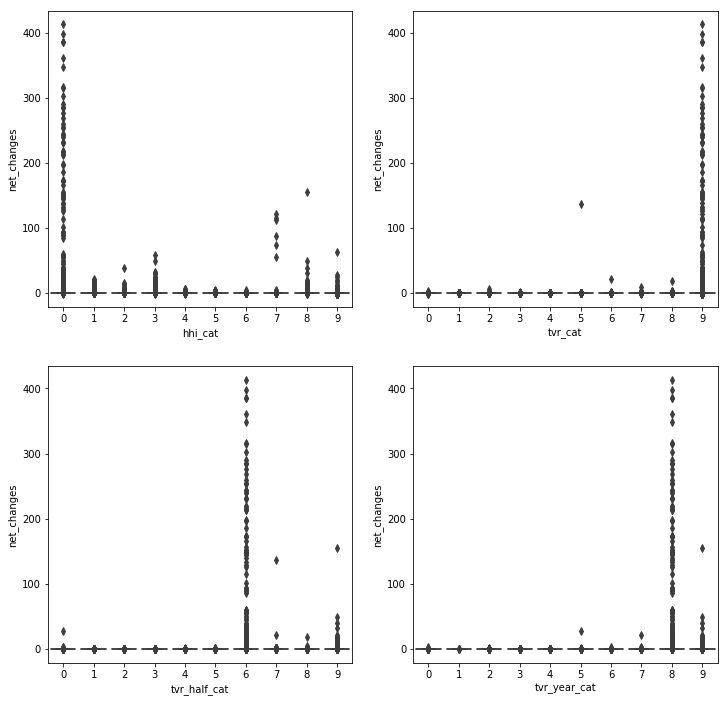

In [189] used 250.7773 MiB RAM in 10.31s, peaked 5.60 MiB above current, total RAM usage 2498.11 MiB


In [189]:
fig, ax = pl.subplots(2,2, figsize=(12,12));
sns.boxplot(x='hhi_cat', y='net_changes', data=final_df, ax=ax[0, 0]);
sns.boxplot(x='tvr_cat', y='net_changes', data=final_df, ax=ax[0, 1]);
sns.boxplot(x='tvr_half_cat', y='net_changes', data=final_df, ax=ax[1, 0]);
sns.boxplot(x='tvr_year_cat', y='net_changes', data=final_df, ax=ax[1, 1]);

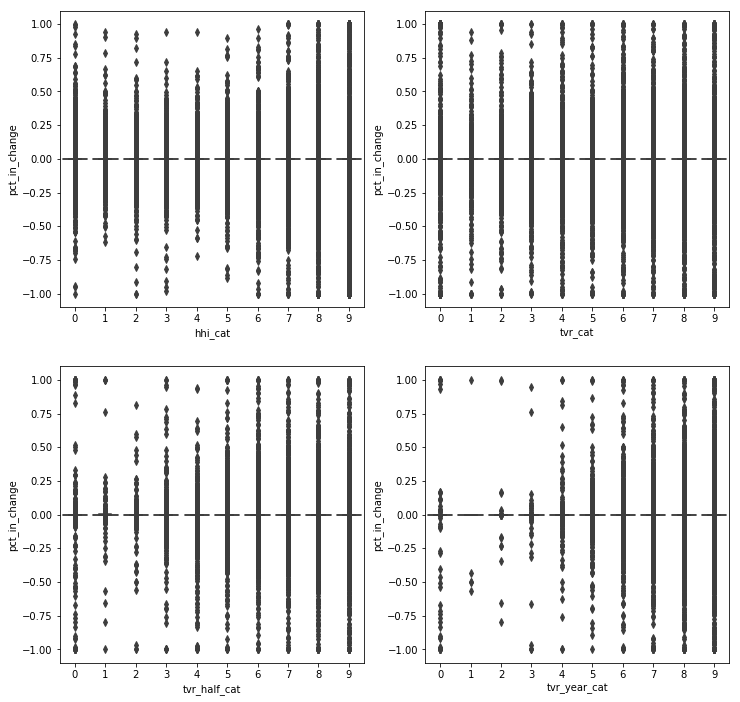

In [190] used 194.6797 MiB RAM in 10.75s, peaked 5.53 MiB above current, total RAM usage 2692.79 MiB


In [190]:
fig, ax = pl.subplots(2,2, figsize=(12,12));
sns.boxplot(x='hhi_cat', y='pct_in_change', data=final_df, ax=ax[0, 0]);
sns.boxplot(x='tvr_cat', y='pct_in_change', data=final_df, ax=ax[0, 1]);
sns.boxplot(x='tvr_half_cat', y='pct_in_change', data=final_df, ax=ax[1, 0]);
sns.boxplot(x='tvr_year_cat', y='pct_in_change', data=final_df, ax=ax[1, 1]);

### Количество акций в портфеле

Сейчас я посмотрю на то, как соотносится количество акций в портфеле с его размером и метриками, расмотренными выше.

Сначала я создам таблицу с данными о количестве позиций у фондов.

In [191]:
# Создаю таблицу количества позиций из агрегированных данных
pos_count = final_df.groupby(['period', 'cik']).count().reset_index()[['period', 'cik', 'shares']]
pos_count.rename(columns={'shares': 'pos_count'}, inplace=True)

pos_count.head()

,period,cik,pos_count
0,2016Q1,5272,3732
1,2016Q1,7789,186
2,2016Q1,9015,1271
3,2016Q1,36644,246
4,2016Q1,38777,2


In [191] used -1307.9414 MiB RAM in 12.60s, peaked 1944.12 MiB above current, total RAM usage 1384.84 MiB


Теперь добавляю эти данные в датасет и пролаггирую их, так как, опять же, нам не доступны данные из периода предсказания.

In [192]:
# Присоединяю новые данные
final_df = final_df.merge(pos_count, on=['period', 'cik'], how='left', suffixes=(False, False))

In [192] used 109.4062 MiB RAM in 7.79s, peaked 1457.94 MiB above current, total RAM usage 1494.25 MiB


Теперь посмотрим на распределение количества позиций в фонде.

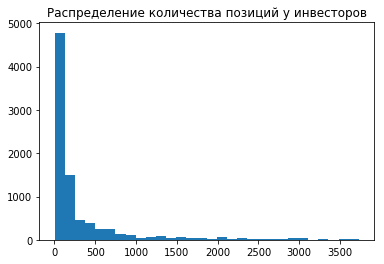

In [193] used 25.3789 MiB RAM in 0.58s, peaked 0.00 MiB above current, total RAM usage 1519.63 MiB


In [193]:
pl.hist(pos_count.pos_count, bins=30);
pl.title('Распределение количества позиций у инвесторов');

Мы видим, что распределение фондов похоже на геометрическое. Тогда разобьем его на классы последовательным извлечением половины. В первом классе будут фонды с количеством позиций, большим 2000. Во втором классе - большим 1000. И в третьем - большим 200. Это не деление по половине, но по гистограмме видно, что количество фондов с количеством позиций, меньшим 200, выбивает из сглаженности распределения, что я воспринимаю как сигнал, чтобы сместить границу разделения. Также я отмечу фонды с количеством позиций, большим 3000 и собирают почти все акции на рынке. Они стоят особняком от основного распределения. Вполне возможно, что те самые индексные и квантовые фонды, которые работают по всей вселенной акций.

In [194]:
final_df['pos_count_cat'] = pd.cut(final_df.pos_count, [-1, 30, 200, 500, 1000, 2000, 3000, 1e32],
                                  labels=['<=30', '30-200', '200-500', '500-1000', '1000-2000', '2000-3000', '>3000'])

In [194] used 4.2461 MiB RAM in 0.26s, peaked 19.97 MiB above current, total RAM usage 1523.88 MiB


Теперь я посмотрю на совместное распределение корня числа позиций и логарифма ценности фонда.

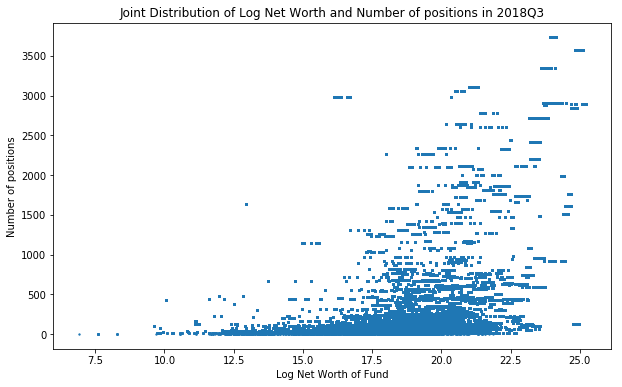

In [195] used 44.8828 MiB RAM in 18.57s, peaked 0.89 MiB above current, total RAM usage 1568.76 MiB


In [195]:
fig, axs = pl.subplots(1, 1, figsize=(10,6));

axs.scatter(final_df.log_value_fund,
            final_df.pos_count, s=1.8);
axs.set_title('Joint Distribution of Log Net Worth and Number of positions in ' + str(final_df.period.max()));
axs.set(xlabel='Log Net Worth of Fund', ylabel='Number of positions');

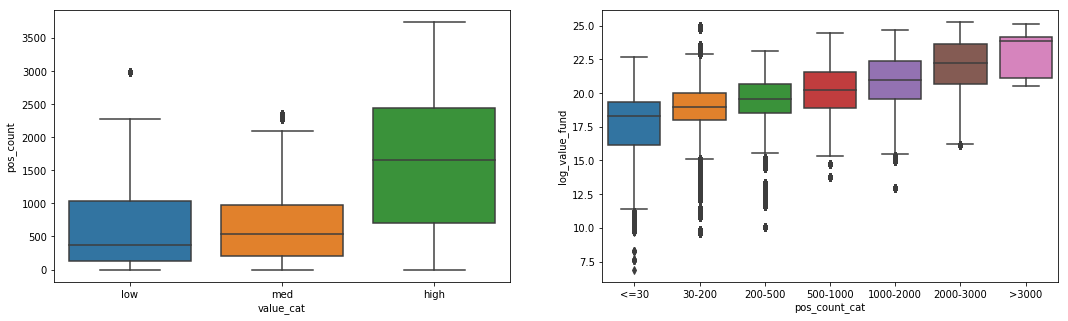

In [196] used 21.5742 MiB RAM in 1.54s, peaked 69.36 MiB above current, total RAM usage 1590.33 MiB


In [196]:
fig, ax = pl.subplots(1,2, figsize=(18,5));
sns.boxplot(x='value_cat', y='pos_count', data=final_df, ax=ax[0]);
sns.boxplot(x='pos_count_cat', y='log_value_fund', data=final_df, ax=ax[1]);

Теперь я посмотрю на распределения корня числа позиций относительно HHI и Turnover.

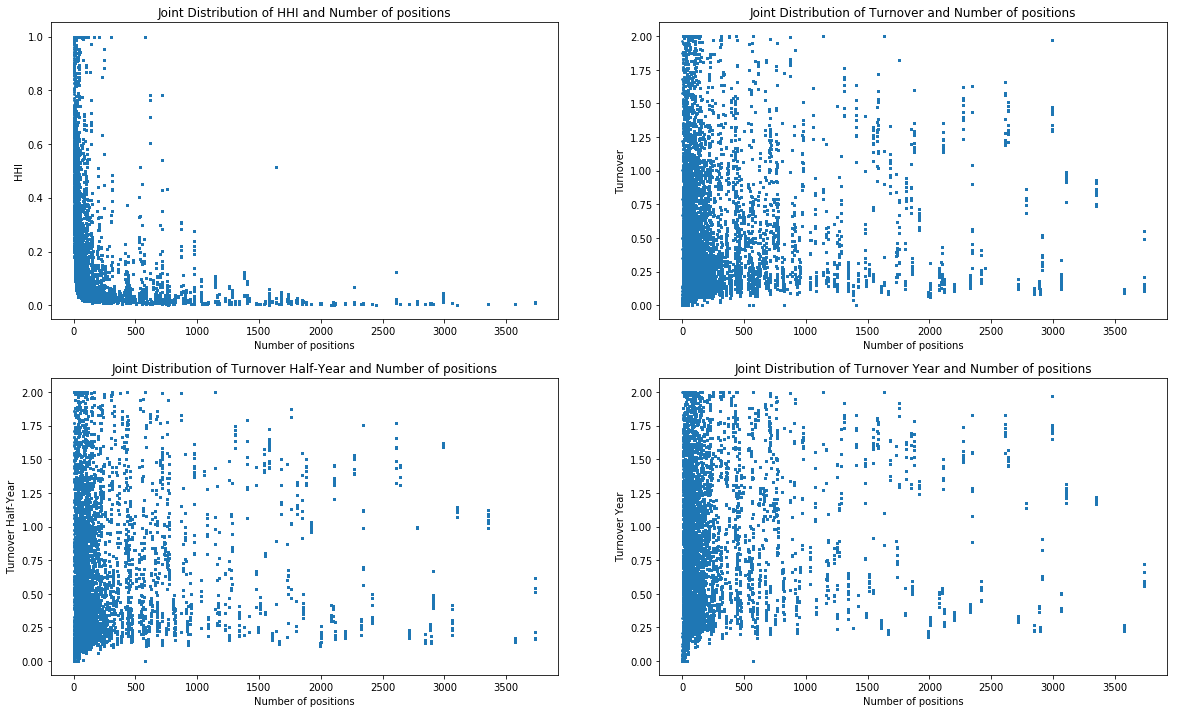

In [197] used 129.4102 MiB RAM in 57.94s, peaked 18.98 MiB above current, total RAM usage 1719.74 MiB


In [197]:
fig, axs = pl.subplots(2, 2, figsize=(20, 12));

axs[0, 0].scatter(final_df.pos_count,
           final_df.hhi, s=1.8);
axs[0, 0].set_title('Joint Distribution of HHI and Number of positions');
axs[0, 0].set(xlabel='Number of positions', ylabel='HHI');

axs[0, 1].scatter(final_df.pos_count,
           final_df.turnover, s=1.8);
axs[0, 1].set_title('Joint Distribution of Turnover and Number of positions');
axs[0, 1].set(xlabel='Number of positions', ylabel='Turnover');

axs[1, 0].scatter(final_df.pos_count,
           final_df.turnover_halfyear, s=1.8);
axs[1, 0].set_title('Joint Distribution of Turnover Half-Year and Number of positions');
axs[1, 0].set(xlabel='Number of positions', ylabel='Turnover Half-Year');

axs[1, 1].scatter(final_df.pos_count,
           final_df.turnover_year, s=1.8);
axs[1, 1].set_title('Joint Distribution of Turnover Year and Number of positions');
axs[1, 1].set(xlabel='Number of positions', ylabel='Turnover Year');

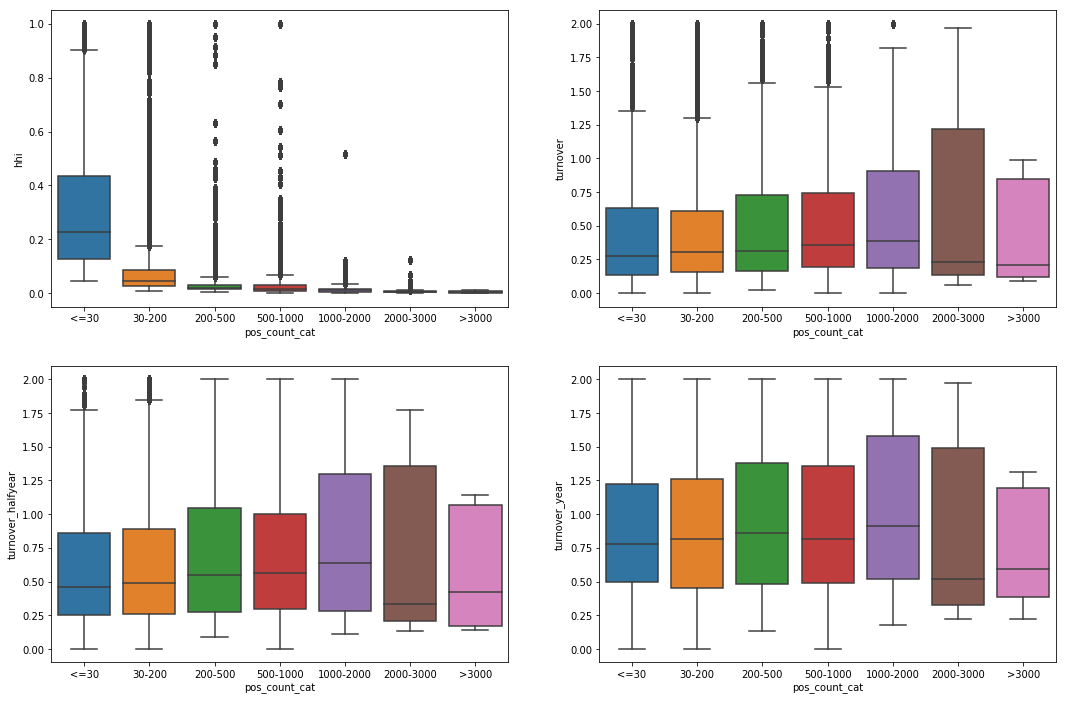

In [198] used 36.8945 MiB RAM in 3.30s, peaked 33.76 MiB above current, total RAM usage 1756.64 MiB


In [198]:
fig, ax = pl.subplots(2, 2, figsize=(18, 12));
sns.boxplot(x='pos_count_cat', y='hhi', data=final_df, ax=ax[0, 0]);
sns.boxplot(x='pos_count_cat', y='turnover', data=final_df, ax=ax[0, 1]);
sns.boxplot(x='pos_count_cat', y='turnover_halfyear', data=final_df, ax=ax[1, 0]);
sns.boxplot(x='pos_count_cat', y='turnover_year', data=final_df, ax=ax[1, 1]);

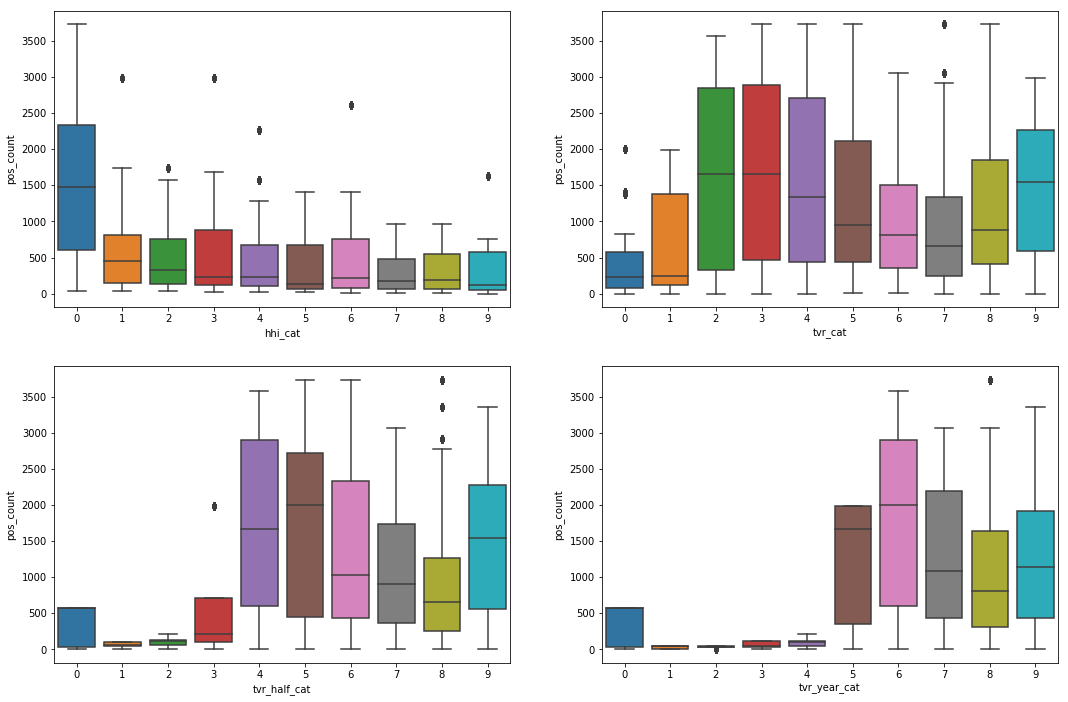

In [199] used 23.2109 MiB RAM in 1.90s, peaked 69.87 MiB above current, total RAM usage 1779.85 MiB


In [199]:
fig, ax = pl.subplots(2, 2, figsize=(18, 12));
sns.boxplot(x='hhi_cat', y='pos_count', data=final_df, ax=ax[0, 0]);
sns.boxplot(x='tvr_cat', y='pos_count', data=final_df, ax=ax[0, 1]);
sns.boxplot(x='tvr_half_cat', y='pos_count', data=final_df, ax=ax[1, 0]);
sns.boxplot(x='tvr_year_cat', y='pos_count', data=final_df, ax=ax[1, 1]);

Связь с зависимой переменной.

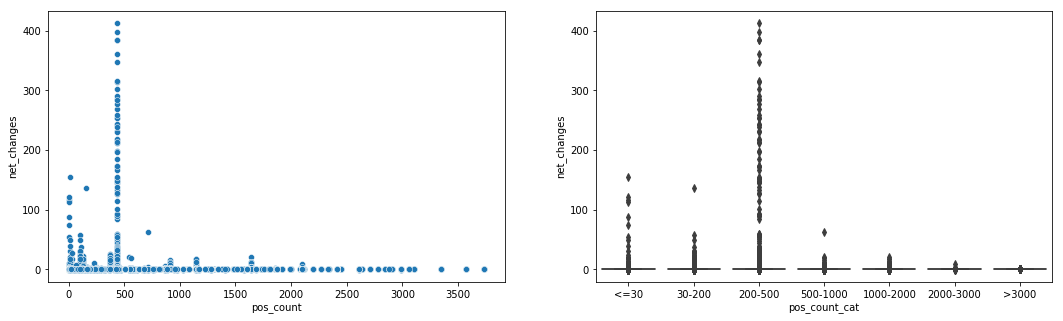

In [200] used 97.7109 MiB RAM in 22.49s, peaked 61.87 MiB above current, total RAM usage 1877.56 MiB


In [200]:
fig, ax = pl.subplots(1,2, figsize=(18,5));
sns.scatterplot(x='pos_count', y='net_changes', data=final_df, ax=ax[0]);
sns.boxplot(x='pos_count_cat', y='net_changes', data=final_df, ax=ax[1]);

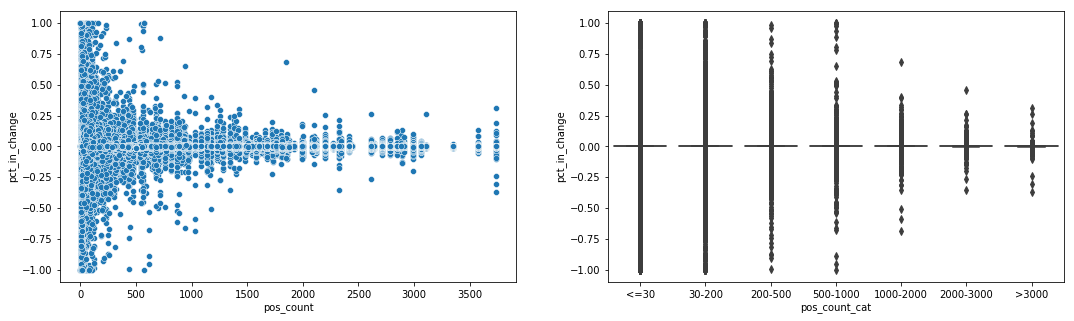

In [201] used 95.0547 MiB RAM in 22.48s, peaked 62.98 MiB above current, total RAM usage 1972.61 MiB


In [201]:
fig, ax = pl.subplots(1,2, figsize=(18,5));
sns.scatterplot(x='pos_count', y='pct_in_change', data=final_df, ax=ax[0]);
sns.boxplot(x='pos_count_cat', y='pct_in_change', data=final_df, ax=ax[1]);

Корреляция переменных, связанных с фондами.

In [202]:
corr = final_df[['log_value_fund', 'value_cat', 'net_changes_abs_sum', 'turnover', 'turnover_halfyear', 'turnover_year',
'hhi', 'hhi_cat', 'tvr_cat', 'tvr_half_cat', 'tvr_year_cat',
'pos_count', 'pos_count_cat']].corr('spearman', min_periods=0)
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,log_value_fund,net_changes_abs_sum,turnover,turnover_halfyear,turnover_year,hhi,pos_count
log_value_fund,1.00,-0.26,-0.29,-0.33,-0.36,-0.57,0.57
net_changes_abs_sum,-0.26,1.00,0.97,0.89,0.83,0.07,0.03
turnover,-0.29,0.97,1.00,0.91,0.86,0.11,0.00
turnover_halfyear,-0.33,0.89,0.91,1.00,0.91,0.14,-0.03
turnover_year,-0.36,0.83,0.86,0.91,1.00,0.22,-0.08
hhi,-0.57,0.07,0.11,0.14,0.22,1.00,-0.70
pos_count,0.57,0.03,0.00,-0.03,-0.08,-0.70,1.00


In [202] used 2.9375 MiB RAM in 14.25s, peaked 1566.71 MiB above current, total RAM usage 1975.55 MiB


Добавление средних изменений зависимых переменных.

In [203]:
%%time

# Составляю таблицы средних изменений позиций по тикеру, периоду и фонду

mean_pct_in_change = final_df.groupby(['ticker_id', 'period'])['pct_in_change'].mean().reset_index()
mean_pct_in_change.rename(columns={'pct_in_change': 'mean_pct_in_change'}, inplace=True)

mean_pct_in_change_by_cik = final_df.groupby(['cik', 'period'])['pct_in_change'].mean().reset_index()
mean_pct_in_change_by_cik.rename(columns={'pct_in_change': 'mean_pct_in_change_by_cik'}, inplace=True)

mean_pct_in_change_by_value = final_df.groupby(['ticker_id', 'period', 'value_cat']) \
                                                        ['pct_in_change'].mean().reset_index()
mean_pct_in_change_by_value.rename(columns={'pct_in_change': 'mean_pct_in_change_by_value'}, inplace=True)

mean_pct_in_change_by_pos_count = final_df.groupby(['ticker_id', 'period', 'pos_count_cat']) \
                                                        ['pct_in_change'].mean().reset_index()
mean_pct_in_change_by_pos_count.rename(columns={'pct_in_change': 'mean_pct_in_change_by_pos_count'}, inplace=True)



mean_net_changes = final_df.groupby(['ticker_id', 'period'])['net_changes'].mean().reset_index()
mean_net_changes.rename(columns={'net_changes': 'mean_net_changes'}, inplace=True)

mean_net_changes_by_cik = final_df.groupby(['cik', 'period'])['net_changes'].mean().reset_index()
mean_net_changes_by_cik.rename(columns={'net_changes': 'mean_net_changes_by_cik'}, inplace=True)

mean_net_changes_by_value = final_df.groupby(['ticker_id', 'period', 'value_cat']) \
                                                        ['net_changes'].mean().reset_index()
mean_net_changes_by_value.rename(columns={'net_changes': 'mean_net_changes_by_value'}, inplace=True)

mean_net_changes_by_pos_count = final_df.groupby(['ticker_id', 'period', 'pos_count_cat']) \
                                                        ['net_changes'].mean().reset_index()
mean_net_changes_by_pos_count.rename(columns={'net_changes': 'mean_net_changes_by_pos_count'}, inplace=True)

# Сцепляю их с нашим датасетом

final_df = final_df.merge(mean_pct_in_change, on=['ticker_id', 'period'], how='left', suffixes=(False, False))
final_df = final_df.merge(mean_pct_in_change_by_cik, on=['cik', 'period'], how='left', suffixes=(False, False))
final_df = final_df.merge(mean_pct_in_change_by_value, on=['ticker_id', 'period', 'value_cat'],
                                                                  how='left', suffixes=(False, False))
final_df = final_df.merge(mean_pct_in_change_by_pos_count, on=['ticker_id', 'period', 'pos_count_cat'],
                                                                  how='left', suffixes=(False, False))


final_df = final_df.merge(mean_net_changes, on=['ticker_id', 'period'], how='left', suffixes=(False, False))
final_df = final_df.merge(mean_net_changes_by_cik, on=['cik', 'period'], how='left', suffixes=(False, False))
final_df = final_df.merge(mean_net_changes_by_value, on=['ticker_id', 'period', 'value_cat'],
                                                                  how='left', suffixes=(False, False))
final_df = final_df.merge(mean_net_changes_by_pos_count, on=['ticker_id', 'period', 'pos_count_cat'],
                                                                  how='left', suffixes=(False, False))

# Считаю количество фондов, владеющих тикером в каждом периоде, чтобы вычесть потом долю отдельного фонда в среднем по тикеру

tickers_count = final_df.groupby(['ticker_id', 'period']).count().reset_index()
tickers_count_by_value = final_df.groupby(['ticker_id', 'period', 'value_cat'])\
                                                            .count().reset_index()
tickers_count_by_pos_count = final_df.groupby(['ticker_id', 'period', 'pos_count_cat'])\
                                                            .count().reset_index()

tickers_count.rename(columns={'shares': 'tickers_count'}, inplace=True)
tickers_count_by_value.rename(columns={'shares': 'tickers_count_by_value'}, inplace=True)
tickers_count_by_pos_count.rename(columns={'shares': 'tickers_count_by_pos_count'}, inplace=True)

final_df = final_df.merge(tickers_count[['ticker_id', 'period', 'tickers_count']], on=['ticker_id', 'period'],
                                                                                          how='left', suffixes=(False, False))

final_df = final_df.merge(tickers_count_by_value[['ticker_id', 'period', 'value_cat', 'tickers_count_by_value']], 
                                                                        on=['ticker_id', 'period', 'value_cat'],
                                                                                          how='left', suffixes=(False, False))
final_df = final_df.merge(tickers_count_by_pos_count[['ticker_id', 'period', 'pos_count_cat', 'tickers_count_by_pos_count']], 
                                                                        on=['ticker_id', 'period', 'pos_count_cat'],
                                                                                          how='left', suffixes=(False, False))

# Вычитаю из среднего по тикеру составляющую конкретного фонда в нем для каждого наблюдения
# Тем самым, я получаю среднее по всем остальным фондам

final_df['mean_pct_in_change'] -= final_df.pct_in_change.div(final_df.tickers_count, axis=0).values
final_df['mean_pct_in_change_by_cik'] -= final_df.pct_in_change.div(final_df.pos_count, axis=0).values
final_df['mean_pct_in_change_by_value'] -= final_df.pct_in_change.div(final_df.tickers_count_by_value, axis=0).values
final_df['mean_pct_in_change_by_pos_count'] -= final_df.pct_in_change.div(final_df.tickers_count_by_pos_count, axis=0).values

final_df['mean_net_changes'] -= final_df.net_changes.div(final_df.tickers_count, axis=0).values
final_df['mean_net_changes_by_cik'] -= final_df.net_changes.div(final_df.pos_count, axis=0).values
final_df['mean_net_changes_by_value'] -= final_df.net_changes.div(final_df.tickers_count_by_value, axis=0).values
final_df['mean_net_changes_by_pos_count'] -= final_df.net_changes.div(final_df.tickers_count_by_pos_count, axis=0).values

Wall time: 1min 3s
In [203] used 562.8672 MiB RAM in 64.05s, peaked 2136.80 MiB above current, total RAM usage 2538.42 MiB


In [204]:
from janitor import groupby_agg

ticker_value = final_df.groupby(['period', 'ticker_id'])['market_value'].sum().reset_index()
ticker_value.rename(columns={'market_value': 'market_value_ticker'}, inplace=True)
ticker_value = ticker_value.groupby_agg(
    by='period',
    agg='sum',
    agg_column_name='market_value_ticker',
    new_column_name='tickers_total_value'
)

ticker_value['ticker_market_share'] = ticker_value.market_value_ticker.div(ticker_value.tickers_total_value.add(1e-20), axis=0)

final_df = final_df.merge(ticker_value, on=['period', 'ticker_id'], how='left', suffixes=(None, None))
final_df['bench_dev'] =  (final_df.ticker_share - final_df.ticker_market_share).abs() / 2
final_df['active_share'] = final_df.groupby(['period', 'cik']).bench_dev.transform('sum')
final_df['log_market_value_ticker'] = np.log(final_df.market_value_ticker.add(1e-20))

ticker_value.head(10)

,period,ticker_id,market_value_ticker,tickers_total_value,ticker_market_share
0,2016Q1,779,27377000.0,9.534662e+11,2.871313e-05
1,2016Q1,780,27481000.0,9.534662e+11,2.882221e-05
2,2016Q1,784,31055000.0,9.534662e+11,3.257063e-05
3,2016Q1,829,75178000.0,9.534662e+11,7.884705e-05
4,2016Q1,835,15691000.0,9.534662e+11,1.645680e-05
5,2016Q1,838,228000.0,9.534662e+11,2.391275e-07
6,2016Q1,850,0.0,9.534662e+11,0.000000e+00
7,2016Q1,872,13669000.0,9.534662e+11,1.433611e-05
8,2016Q1,902,70888000.0,9.534662e+11,7.434768e-05
9,2016Q1,932,10838790.0,9.534662e+11,1.136778e-05


In [204] used 132.0312 MiB RAM in 2.71s, peaked 1272.83 MiB above current, total RAM usage 2670.45 MiB


<h2> Макро-индикаторы </h2>

Я предполагаю, что инвесторы обращают внимание на макроэкономическую ситуацию и её изменение <i>(иначе зачем макроэкономику преподают и изучают)</i>, чтобы исправлять свои стратегии.

<b> Поэтому я считаю, что важно проконтролировать изменение макроэкономических параметров в модели, так как без этого их влияние войдет в остаток, а я хочу, чтобы в остатках лежало только настроение фонда относительно тикера, определяемое его новыми инсайтами, а не экзогенными факторами. </b>

Я буду пользоваться парсером pandas, чтобы получать данные из статистической службы FRED.

В качестве переменных я собираюсь использовать поквартальное изменение ключевой ставки, ставки по десятилетним казначейским облигациям, уровню инфляции и росту ВВП (последние два тоже поквартальные).

In [205]:
import pandas_datareader as wb

In [205] used 0.0898 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 2670.54 MiB


In [206]:
# скачиваю ставки и нахожу их изменение, группируя по кварталам
rates = wb.DataReader(['DGS10', 'DFF', 'UNRATE'], 'fred', start=2012).resample('Q-DEC').mean().diff() / 100
rates.reset_index(inplace=True)
# Перевожу индекс в нужные единицы измерения
rates.DATE = rates.DATE.dt.to_period('Q')

In [206] used 12.0195 MiB RAM in 1.09s, peaked 0.00 MiB above current, total RAM usage 2682.56 MiB


In [207]:
# Нахожу инфлцяцию через Индекс потребительских цен, группируя по кварталам
inflation = wb.DataReader('CPIAUCSL', 'fred', start=2012).resample('Q-DEC').mean().pct_change()
inflation.reset_index(inplace=True)
# Перевожу индекс в нужные единицы измерения
inflation.DATE = inflation.DATE.dt.to_period('Q')

In [207] used 0.6602 MiB RAM in 0.55s, peaked 0.00 MiB above current, total RAM usage 2683.22 MiB


In [208]:
# Скачиваю данные по ВВП и считаю рост (а тут сразу всё поквартально!)
gdp_growth = wb.DataReader('GDP', 'fred', start=2012).pct_change()
gdp_growth.reset_index(inplace=True)
# Перевожу индекс в нужные единицы измерения
gdp_growth.DATE = gdp_growth.DATE.dt.to_period('Q')

In [208] used 0.2383 MiB RAM in 0.34s, peaked 0.00 MiB above current, total RAM usage 2683.46 MiB


In [209]:
%%time

# Связываю полученные значения с нашим датасетом

final_df = final_df.merge(rates, left_on='period', right_on='DATE', how='left', suffixes=(False, False))
final_df = final_df.merge(inflation, on="DATE", how='left', suffixes=(False, False))
final_df = final_df.merge(gdp_growth, on="DATE", how='left', suffixes=(False, False))
final_df.drop('DATE', axis=1, inplace=True)

Wall time: 11.3 s
In [209] used -812.2383 MiB RAM in 11.46s, peaked 2755.59 MiB above current, total RAM usage 1871.22 MiB


## Формирование датасетов для отдельных задач

Так как у многих активов в фондах может не хватать старших лагов, а также учитывая, что фонды не всегда вкладываются на долгий срок, то я для каждого количества доступных лагов, идущих подряд, начиная с первого, создам отдельный датасет, на котором я буду проводить отдельные испытания моделей. В итоге, у меня будет 4 датасета, в первом будут значения для первого лага, во втором - для первого и второго, и так далее.

Также, я создам 5-й датасет, где не будет ни одного лага, и я на нем буду решать задачу предсказания появления позиции по акции в фонде.

Кроме того, я хочу создать датасет, который бы помогал решить задачу определения ситуаций, когда фонд выходит из тикера, но создание такого датасета представляется чересчур ресурсозатратным, так как мой датасет знает только ситуации, когда фонд владел акциями. Плюс, я не всегда знаю, была ли в обороте та или иная акция в определенный квартал, которая не была ни в одном фонде в тот квартал, но есть в датасете.

In [214]:
%%time

final_df.drop(['access_id', 'conformed_submission_type', 'stamp', 'nid', 'ym_stamp', 'mode_close',
               'hhi_cat',  'value_cat', 'tvr_cat', 'tvr_half_cat', 'tvr_year_cat', 'pos_count_cat'], axis=1, inplace=True)

final_df = final_df.dropna(subset=['net_changes', 'pct_in_change', 'turnover', 'turnover_halfyear', 'turnover_year']).fillna(0)

final_df['enter'] = final_df.shares_lag_1.eq(0) & final_df.shares.ne(0)
final_df['exit'] = final_df.shares_lag_1.ne(0) & final_df.shares.eq(0)

Wall time: 2.44 s
In [214] used 756.6016 MiB RAM in 2.54s, peaked 719.06 MiB above current, total RAM usage 2601.84 MiB


# Совершаем простейшие регрессии (через МНК)

Теперь, когда я определился с переменными, попробую определить характер зависимости чистого изменения позиции от регрессоров. Для красоты представления буду пользоваться библиотекой <i>statsmodels<i/>.

### Модель 1

In [215]:
import statsmodels.api as sm

In [215] used 34.8438 MiB RAM in 1.23s, peaked 0.00 MiB above current, total RAM usage 2636.69 MiB


In [216]:
data_common = final_df[~final_df.exit & ~final_df.enter]

In [216] used 643.3477 MiB RAM in 0.85s, peaked 0.00 MiB above current, total RAM usage 3280.04 MiB


In [228]:
y = data_common['pct_in_change']

X = data_common[['log_value_fund',
       'diff_value_fund_rank_lag_1', 'diff_value_fund_rank_lag_2',
       'diff_value_fund_rank_lag_3', 'diff_value_fund_rank_lag_4', 'ticker_share',
       'pct_in_change_1', 'pct_in_change_2', 'pct_in_change_3', 'pct_in_change_4',
       'turnover', 'turnover_halfyear', 'turnover_year',
       'hhi', 'hhi_eq_1', 'pos_count',
       'mean_pct_in_change', 'mean_pct_in_change_by_cik',
       'mean_pct_in_change_by_value', 'mean_pct_in_change_by_pos_count', 'tickers_count',
       'tickers_count_by_value', 'log_market_value_ticker',
       'ticker_market_share', 'bench_dev', 'active_share']].astype('float64')
X = sm.add_constant(X)

In [228] used -1009.1602 MiB RAM in 1.00s, peaked 623.88 MiB above current, total RAM usage 1845.70 MiB


Делаю первую модель. Простой метод наименьших квадратов.

In [229]:
model_1 = sm.OLS(y, X).fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          pct_in_change   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     1025.
Date:                Sun, 20 Dec 2020   Prob (F-statistic):               0.00
Time:                        17:26:13   Log-Likelihood:             3.3037e+06
No. Observations:             1232897   AIC:                        -6.607e+06
Df Residuals:                 1232870   BIC:                        -6.607e+06
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               0.0011      0.000      3.787      0.000       0.001       0.002
log_value_fund                  -6.175e-05   1.39e-05     -4.456      0.000   -8.89e-05   -3.46e-05
diff_value_fund_rank_lag_1          0.0009   5.76e-05     15.818      0.000       0.001       0.001
diff_value_fund_rank_lag_2          0.0002   5.64e-05      2.835      0.005    4.93e-05       0.000
diff_value_fund_rank_lag_3       8.291e-05   5.73e-05      1.447      0.148   -2.94e-05       0.000
diff_value_fund_rank_lag_4       8.788e-05   6.23e-05      1.410      0.158   -3.42e-05       0.000
ticker_share                       -0.0515      0.008     -6.107      0.000      -0.068      -0.035
pct_in_change_1                     0.0680      0.001    101.937      0.000       0.067       0.069
pct_in_change_2                     0.0472      0.001     72.192      0.000       0.046       0.049
pct_in_change_3                     0.0078      0.001     11.988      0.000       0.007       0.009
pct_in_change_4                     0.0091      0.001     12.784      0.000       0.008       0.011
turnover                         2.669e-05   7.45e-05      0.358      0.720      -0.000       0.000
turnover_halfyear                8.954e-05   8.28e-05      1.082      0.279   -7.27e-05       0.000
turnover_year                    5.252e-05   6.44e-05      0.816      0.414   -7.36e-05       0.000
hhi                                -0.0007      0.000     -3.057      0.002      -0.001      -0.000
hhi_eq_1                            0.0021      0.000      6.617      0.000       0.001       0.003
pos_count                       -3.818e-08   1.98e-08     -1.931      0.053   -7.69e-08    5.65e-10
mean_pct_in_change                  0.0394      0.005      8.326      0.000       0.030       0.049
mean_pct_in_change_by_cik           0.1659      0.003     63.493      0.000       0.161       0.171
mean_pct_in_change_by_value         0.0174      0.003      6.292      0.000       0.012       0.023
mean_pct_in_change_by_pos_count     0.1324      0.002     59.624      0.000       0.128       0.137
tickers_count                   -7.402e-07   5.02e-07     -1.473      0.141   -1.72e-06    2.44e-07
tickers_count_by_value           1.936e-06   1.01e-06      1.911      0.056   -4.91e-08    3.92e-06
log_market_value_ticker         -1.742e-05   2.69e-06     -6.482      0.000   -2.27e-05   -1.22e-05
ticker_market_share                -0.0047      0.012     -0.374      0.709      -0.029       0.020
bench_dev                           0.0665      0.017      3.895      0.000       0.033       0.100
active_share                       -0.0003      0.000     -2.094      0.036      -0.001   -2.02e-05
==============================================================================
Omni

In [229] used -234.8398 MiB RAM in 4.58s, peaked 1006.24 MiB above current, total RAM usage 1610.86 MiB


<b>MemoryError, когда хочу использовать матрицу робастных стандартных ошибок.

В результатах написано, что присутствует сильная мультиколлинеарность, но она нас не волнует, так как не влияет на состоятельность оценок.

Создаю меру настроя инвесторов. То, ради чего затевалась курсовая.

In [230]:
# Наша искомая переменная!
delta_1 = y - model_1.predict(X)

In [230] used 0.0469 MiB RAM in 0.18s, peaked 9.41 MiB above current, total RAM usage 1610.91 MiB


Посмотрим на её зависимость от величины активов. Предполагается, что будет наблюдаться некоторая зависимость.

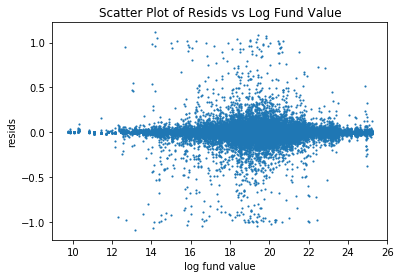

In [231] used 20.4219 MiB RAM in 8.03s, peaked 0.00 MiB above current, total RAM usage 1631.33 MiB


In [231]:
pl.scatter(X.log_value_fund, delta_1, s=1.25);
pl.title('Scatter Plot of Resids vs Log Fund Value');
pl.xlabel('log fund value');
pl.ylabel('resids');

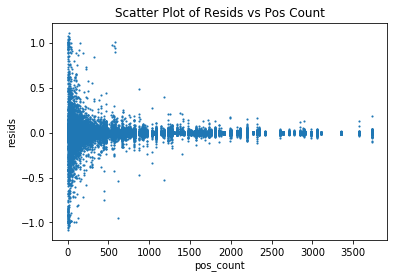

In [232] used 20.2461 MiB RAM in 7.70s, peaked 0.00 MiB above current, total RAM usage 1651.58 MiB


In [232]:
pl.scatter(X.pos_count, delta_1, s=1.25);
pl.title('Scatter Plot of Resids vs Pos Count');
pl.xlabel('pos_count');
pl.ylabel('resids');

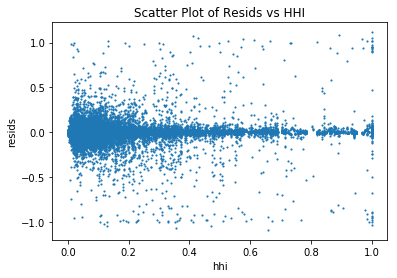

In [233] used 20.0195 MiB RAM in 8.11s, peaked 0.05 MiB above current, total RAM usage 1671.60 MiB


In [233]:
pl.scatter(X.hhi, delta_1, s=1.25);
pl.title('Scatter Plot of Resids vs HHI');
pl.xlabel('hhi');
pl.ylabel('resids');

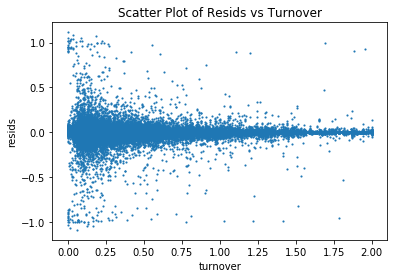

In [234] used 20.0273 MiB RAM in 9.12s, peaked 0.00 MiB above current, total RAM usage 1691.62 MiB


In [234]:
pl.scatter(X.turnover, delta_1, s=1.25);
pl.title('Scatter Plot of Resids vs Turnover');
pl.xlabel('turnover');
pl.ylabel('resids');

Ну это странно.

На графике видно, что остатки какие-то выдающиеся. Посмотрю на гистограмме, есть ли у меня такие наблюдения.

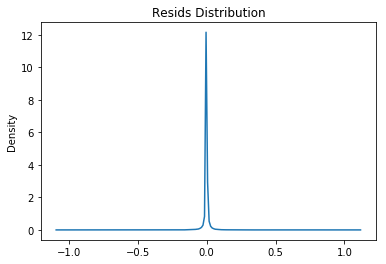

In [235] used 1.2383 MiB RAM in 15.95s, peaked 111.93 MiB above current, total RAM usage 1692.86 MiB


In [235]:
sns.kdeplot(delta_1).set_title("Resids Distribution");

Ну норм.

### Модель 2

In [236]:
y = data_common['pct_in_change']

X = data_common[['log_value_fund',
       'diff_value_fund_rank_lag_1', 'diff_value_fund_rank_lag_2',
       'diff_value_fund_rank_lag_3', 'diff_value_fund_rank_lag_4', 'ticker_share',
       'pct_in_change_1', 'pct_in_change_2', 'pct_in_change_3', 'pct_in_change_4',
       'turnover', 'turnover_halfyear', 'turnover_year',
       'hhi', 'hhi_eq_1', 'pos_count',
       'mean_pct_in_change', 'mean_pct_in_change_by_cik',
       'mean_pct_in_change_by_value', 'mean_pct_in_change_by_pos_count', 'tickers_count',
       'tickers_count_by_value', 'log_market_value_ticker',
       'ticker_market_share', 'bench_dev', 'active_share',
        'DGS10', 'DFF', 'UNRATE',
        'CPIAUCSL', 'GDP']].astype('float64')
X = sm.add_constant(X)

In [236] used 301.0391 MiB RAM in 1.13s, peaked 760.47 MiB above current, total RAM usage 1993.90 MiB


In [237]:
model_2 = sm.OLS(y, X).fit()
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          pct_in_change   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     861.3
Date:                Sun, 20 Dec 2020   Prob (F-statistic):               0.00
Time:                        17:27:20   Log-Likelihood:             3.3037e+06
No. Observations:             1232897   AIC:                        -6.607e+06
Df Residuals:                 1232865   BIC:                        -6.607e+06
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               0.0024      0.000      5.317      0.000       0.002       0.003
log_value_fund                  -6.375e-05   1.39e-05     -4.593      0.000    -9.1e-05   -3.65e-05
diff_value_fund_rank_lag_1          0.0010   5.99e-05     17.008      0.000       0.001       0.001
diff_value_fund_rank_lag_2          0.0001   5.88e-05      2.206      0.027    1.45e-05       0.000
diff_value_fund_rank_lag_3       2.232e-05   5.88e-05      0.380      0.704   -9.29e-05       0.000
diff_value_fund_rank_lag_4          0.0001   6.28e-05      1.966      0.049    3.62e-07       0.000
ticker_share                       -0.0514      0.008     -6.100      0.000      -0.068      -0.035
pct_in_change_1                     0.0680      0.001    101.936      0.000       0.067       0.069
pct_in_change_2                     0.0473      0.001     72.224      0.000       0.046       0.049
pct_in_change_3                     0.0078      0.001     11.969      0.000       0.007       0.009
pct_in_change_4                     0.0091      0.001     12.796      0.000       0.008       0.011
turnover                         2.775e-05   7.47e-05      0.372      0.710      -0.000       0.000
turnover_halfyear                9.408e-05   8.28e-05      1.136      0.256   -6.83e-05       0.000
turnover_year                    4.906e-05   6.44e-05      0.762      0.446   -7.71e-05       0.000
hhi                                -0.0008      0.000     -3.288      0.001      -0.001      -0.000
hhi_eq_1                            0.0022      0.000      6.810      0.000       0.002       0.003
pos_count                       -4.112e-08   1.98e-08     -2.079      0.038   -7.99e-08   -2.35e-09
mean_pct_in_change                  0.0391      0.005      8.253      0.000       0.030       0.048
mean_pct_in_change_by_cik           0.1652      0.003     63.182      0.000       0.160       0.170
mean_pct_in_change_by_value         0.0174      0.003      6.278      0.000       0.012       0.023
mean_pct_in_change_by_pos_count     0.1324      0.002     59.618      0.000       0.128       0.137
tickers_count                   -6.872e-07   5.03e-07     -1.367      0.172   -1.67e-06    2.98e-07
tickers_count_by_value           1.759e-06   1.01e-06      1.735      0.083   -2.29e-07    3.75e-06
log_market_value_ticker         -1.731e-05   2.69e-06     -6.440      0.000   -2.26e-05    -1.2e-05
ticker_market_share                -0.0044      0.012     -0.356      0.722      -0.029       0.020
bench_dev                           0.0664      0.017      3.890      0.000       0.033       0.100
active_share                       -0.0003      0.000     -2.081      0.037      -0.001   -1.83e-05
DGS10                               0.1574      0.038      4.174      0.000       0

In [237] used -281.8047 MiB RAM in 5.36s, peaked 1194.41 MiB above current, total RAM usage 1712.10 MiB


(Тут старые объяснения)

Наблюдается отрицательная зависимость от безработицы, положительная от инфляции и отрицательная от роста ВВП.
Первая зависимость интиутивно понятно. Низкая безработица свидетельствует о росте экономики, который наблюдается последнее время, а во время роста увеличиваются вложения в финансовые активы. Если рост вызван увеличением предложения, то ещё более очевидно, что улучшение ситуации у эмитентов делает их более привлекательным.

Вторая и третья зависимость не так очевидна, но у меня есть объяснение. Увеличение инфляции и падение выпуска происходит при уменьшении совокупного предложения. Это говорит об ухудшении положении эмитентов. Тем не менее, стоит вспомнить про то, что бизнес-циклы неотъемлемая часть экономики. И в такой ситуации очевидно наблюдается спад. Мы знаем, как и все, что после спада наступает рост. А во время роста (см. абзац выше) увеличивается спрос на финансовые активы и, как следствие, цена на них. Значит, инвестор может купить акции сейчас дешевле и продать их во время бума подороже. Наверно, так можно объяснить эти коэффициенты.

Положительная зависимость от ключевой ставки объясняется тем, что увеличение ставки может быть представлено как контр-мера против перегревания экономики во время экономического бума, а поведение во время бума я уже описывал.

Если надо, то я могу воспользоваться IS-LM моделью, чтобы более подробно попытаться объяснить зависимость и логику.

Заметим, что несмотря на свою красоту эта модель, как и предыдущие, имеет маленький R^2, то есть, имеет маленькую предсказательную способность и мало объясняет дисперсию изменения.
Но мы уже видели, что дисперсия так рознится из-за проблемы с малыми фондами и проблемы масштаба.

Главное, что наша модель имеет <b>прикладной и экономический смысл</b>!

### Модель 3

In [238]:
y = data_common['net_changes']

X = data_common[['log_value_fund',
       'diff_value_fund_rank_lag_1', 'diff_value_fund_rank_lag_2',
       'diff_value_fund_rank_lag_3', 'diff_value_fund_rank_lag_4', 'ticker_share',
       'net_changes_1', 'net_changes_2', 'net_changes_3', 'net_changes_4',
       'turnover', 'turnover_halfyear', 'turnover_year',
       'hhi', 'hhi_eq_1', 'pos_count', 'tickers_count',
       'mean_net_changes',
       'mean_net_changes_by_cik', 'mean_net_changes_by_value',
       'mean_net_changes_by_pos_count',
       'tickers_count_by_value', 'log_market_value_ticker', 'tickers_total_value',
       'ticker_market_share', 'bench_dev', 'active_share',
        'DGS10', 'DFF', 'UNRATE',
        'CPIAUCSL', 'GDP']].astype('float64')
X = sm.add_constant(X)

In [238] used 393.1367 MiB RAM in 1.23s, peaked 873.08 MiB above current, total RAM usage 2105.23 MiB


In [239]:
model_3 = sm.OLS(y, X).fit()
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            net_changes   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     24.66
Date:                Sun, 20 Dec 2020   Prob (F-statistic):          4.58e-114
Time:                        17:28:02   Log-Likelihood:             7.3275e+05
No. Observations:             1232897   AIC:                        -1.465e+06
Df Residuals:                 1232871   BIC:                        -1.465e+06
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             0.0009      0.003      0.292      0.770      -0.005       0.007
log_value_fund                 -3.83e-05      0.000     -0.344      0.731      -0.000       0.000
diff_value_fund_rank_lag_1        0.0008      0.000      1.811      0.070   -6.92e-05       0.002
diff_value_fund_rank_lag_2        0.0003      0.000      0.658      0.511      -0.001       0.001
diff_value_fund_rank_lag_3        0.0003      0.000      0.637      0.524      -0.001       0.001
diff_value_fund_rank_lag_4     2.143e-05      0.001      0.042      0.966      -0.001       0.001
ticker_share                      0.0319      0.005      6.609      0.000       0.022       0.041
net_changes_1                 -2.619e-05   7.95e-05     -0.329      0.742      -0.000       0.000
net_changes_2                    -0.0001      0.001     -0.242      0.809      -0.001       0.001
net_changes_3                    -0.0002      0.001     -0.312      0.755      -0.001       0.001
net_changes_4                    -0.0001      0.001     -0.203      0.839      -0.001       0.001
turnover                         -0.0011      0.001     -1.749      0.080      -0.002       0.000
turnover_halfyear                 0.0013      0.001      1.935      0.053   -1.66e-05       0.003
turnover_year                     0.0003      0.001      0.610      0.542      -0.001       0.001
hhi                              -0.0018      0.002     -0.985      0.325      -0.005       0.002
hhi_eq_1                          0.0010      0.003      0.400      0.689      -0.004       0.006
pos_count                     -9.633e-08   1.59e-07     -0.605      0.545   -4.08e-07    2.16e-07
tickers_count                  2.473e-06   3.53e-06      0.702      0.483   -4.44e-06    9.38e-06
mean_net_changes                 -0.0006      0.002     -0.356      0.722      -0.004       0.003
mean_net_changes_by_cik           0.0074      0.000     23.489      0.000       0.007       0.008
mean_net_changes_by_value         0.0007      0.001      0.829      0.407      -0.001       0.002
mean_net_changes_by_pos_count     0.0007      0.001      1.183      0.237      -0.000       0.002
tickers_count_by_value        -4.802e-06   8.12e-06     -0.591      0.554   -2.07e-05    1.11e-05
log_market_value_ticker        7.375e-06   2.15e-05      0.343      0.731   -3.47e-05    4.95e-05
tickers_total_value            3.192e-16   1.45e-15      0.221      0.825   -2.51e-15    3.15e-15
ticker_market_share               0.0088      0.026      0.340      0.734      -0.042       0.059
bench_dev                         0.0145      0.003      4.564      0.000       0.008       0.021
active_share                     -0.0019      0.001     -1.604      0.109      -0.004       0.000
DGS10                            -0.0307     

In [239] used 284.9883 MiB RAM in 4.78s, peaked 956.91 MiB above current, total RAM usage 2390.22 MiB


### Модель 4

In [249]:
y = final_df['enter']

X = final_df[['log_value_fund',
       'diff_value_fund_rank_lag_1', 'diff_value_fund_rank_lag_2',
       'diff_value_fund_rank_lag_3', 'diff_value_fund_rank_lag_4',
       'pct_in_change_1', 'pct_in_change_2', 'pct_in_change_3', 'pct_in_change_4',
       'net_changes_1', 'net_changes_2', 'net_changes_3', 'net_changes_4',
       'turnover', 'turnover_halfyear', 'turnover_year',
       'hhi', 'hhi_eq_1', 'pos_count',
       'mean_pct_in_change', 'mean_pct_in_change_by_cik',
       'mean_pct_in_change_by_value', 'mean_pct_in_change_by_pos_count', 
       'mean_net_changes',
       'mean_net_changes_by_cik', 'mean_net_changes_by_value',
       'mean_net_changes_by_pos_count', 'tickers_count',
       'tickers_count_by_value', 'log_market_value_ticker',
       'ticker_market_share', 'bench_dev', 'active_share',
        'DGS10', 'DFF', 'UNRATE', 'CPIAUCSL', 'GDP']].astype('float64')
X = sm.add_constant(X)

In [249] used -128.1328 MiB RAM in 3.56s, peaked 1464.05 MiB above current, total RAM usage 737.75 MiB


In [251]:
model_4 = sm.Logit(y, X).fit()
print(model_4.summary())

                           Logit Regression Results                           
Dep. Variable:                  enter   No. Observations:              1451023
Model:                          Logit   Df Residuals:                  1450984
Method:                           MLE   Df Model:                           38
Date:                Sun, 20 Dec 2020   Pseudo R-squ.:                 0.06162
Time:                        17:37:52   Log-Likelihood:            -3.6666e+05
converged:                       True   LL-Null:                   -3.9074e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -6.0575      0.104    -58.001      0.000      -6.262      -5.853
log_value_fund                      0.0280      0.003      9.109    

### Модель 5

In [253]:
y = final_df['exit']

X = final_df[['log_value_fund',
       'diff_value_fund_rank_lag_1', 'diff_value_fund_rank_lag_2',
       'diff_value_fund_rank_lag_3', 'diff_value_fund_rank_lag_4',
       'pct_in_change_1', 'pct_in_change_2', 'pct_in_change_3', 'pct_in_change_4',
       'net_changes_1', 'net_changes_2', 'net_changes_3', 'net_changes_4',
       'turnover', 'turnover_halfyear', 'turnover_year',
       'hhi', 'hhi_eq_1', 'pos_count',
       'mean_pct_in_change', 'mean_pct_in_change_by_cik',
       'mean_pct_in_change_by_value', 'mean_pct_in_change_by_pos_count', 
       'mean_net_changes',
       'mean_net_changes_by_cik', 'mean_net_changes_by_value',
       'mean_net_changes_by_pos_count', 'tickers_count',
       'tickers_count_by_value', 'log_market_value_ticker',
       'ticker_market_share', 'bench_dev', 'active_share',
        'DGS10', 'DFF', 'UNRATE', 'CPIAUCSL', 'GDP']].astype('float64')
X = sm.add_constant(X)

In [253] used 311.4609 MiB RAM in 22.03s, peaked 547.54 MiB above current, total RAM usage 451.66 MiB


In [254]:
model_5 = sm.Logit(y, X).fit()
print(model_5.summary())

Optimization terminated successfully.
         Current function value: 0.237236
         Iterations 14
                           Logit Regression Results                           
Dep. Variable:                   exit   No. Observations:              1451023
Model:                          Logit   Df Residuals:                  1450984
Method:                           MLE   Df Model:                           38
Date:                Sun, 20 Dec 2020   Pseudo R-squ.:                  0.1024
Time:                        17:40:46   Log-Likelihood:            -3.4424e+05
converged:                       True   LL-Null:                   -3.8349e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -3.2100      0.097    -33.136 

# Сохранение датасета.

Для удобства сохраню полученные результаты.

In [54]:
import pickle

# сохраняю полный датасет
with open('final_df.pkl', 'wb') as f:
    pickle.dump(final_df, f, protocol=-1)

In [54] used 1418.7266 MiB RAM in 52.11s, peaked 963.24 MiB above current, total RAM usage 1988.16 MiB


# Планируемая работа

4. Понять, надо ли оставлять в данных, на которых я буду тренировать бустинги, леса и прочие чудеса, кросс-произведения дохода и других непрерывных переменных или достаточно будет использовать все переменные по отдельности, ведь всех можно применить PolynomialFeatures.<br><br> (Разобрались)<br><br>

5. Понять, как лучше разделять данные на тест и трейн.<br><br> <b>(Непонятно)</b><br><br>

the coursework will return ...